<h1>Preliminaries</h1>
<p>This codebase was originally created by the team behind the following paper:</p>
<p><strong>Radioactive data: tracing through training</strong><br />
    <a href="https://arxiv.org/pdf/2002.00937.pdf">https://arxiv.org/pdf/2002.00937.pdf</a>
        </p>
    
<p>We have made some quality of life changes and created this notebook to help others learn faster. The demonstration
will: </p>
   <ol>
       <li>Mark a certain subset of the CIFAR10 dataset (target data) using a resnet18 pretrained on imagenet (marking network)</li>
       <li>Use the modified CIFAR10 dataset to train a new resnet18 (target network)</li>
       <li>Attempt to detect radioactivity in the target network</li>
    </ol>
</p>
<p><strong>Note:</strong><br/>
In our example the marking network is pretrained on imagenet, while our target data is CIFAR10.
According to section 5.5 of the paper, even a marking network trained on a different
data distribution will output radioactive markings that are useful when applied to at least 10% of the dataset. 
This number could vary, we are just quoting the minimum radioactive data percentage shown in the paper. </p>
<p>If the marking network was trained on the same data distribution it is likely that a lower percentage of the
   target data would require marking to achieve the same p value in the detection stage.</p>

<h1>Creating Radioactive Data (Image Marking)</h1>

<h2>Prepare Dataset</h2>
<ol>
    <li>Download the CIFAR10 dataset which has 10 classes.</li>
    <li>Randomly choose an image class and sample a certain percentage of the images for saving to "img/data".</li>
    <li>Save these images to "img/data" along with a file containing a list of image paths to pass into <em>make_data_radioactive.py</em>.</li>
</ol>

In [3]:
import torchvision
import torch
import random
import os
import shutil
import tqdm

# Download CIFAR10 dataset
train_set = torchvision.datasets.CIFAR10(root="data/datasets", download=True)

# Index images by class
images_by_class = [[] for x in train_set.classes]
for index, (img, label) in enumerate(train_set):
    images_by_class[label].append(index)

# Randomly choose an image class
chosen_image_class = random.choice(list(range(0, len(train_set.classes))))
print(f"Randomly selected image class {chosen_image_class} ({train_set.classes[chosen_image_class]})", flush=True)

# Randomly sample images from that class
data_marking_percentage = 10
total_marked_in_class = int(len(images_by_class[chosen_image_class]) * (data_marking_percentage / 100))
train_marked_indexes = random.sample(images_by_class[chosen_image_class], total_marked_in_class)

# Save these images for marking to /data/img and build list file
image_dir_path = "data/img"
shutil.rmtree(image_dir_path, ignore_errors=True)
os.makedirs(image_dir_path)

print(f"Saving {total_marked_in_class} images randomly sampled from class.", flush=True)
image_list = []
for i in tqdm.tqdm(train_marked_indexes):
    image, _ = train_set[i]
    image_path = f"{image_dir_path}/train_{i}.png"
    with open(image_path, 'wb') as fh:
        img = image.save(fh)
    image_list.append(image_path)
     
train_image_list_path = "data/train_img_list.txt"
torch.save(image_list, train_image_list_path)

Files already downloaded and verified
Randomly selected image class 4 (deer)
Saving 500 images randomly sampled from class.


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1556.26it/s]


<h2>Download Marking Network And Save For Later</h2>
<p>Further down, <em>make_data_radioactive.py</em> will create a new torchvision.models.[architecture](marking_network_classes) and load the state dictionary from the pretrained model. After loading, the fully connected layer is removed, allowing us to mark on any number of classes.</p>

In [5]:
import torch
from torchvision import models

marking_network_fc_feature_size = 512 # Used Further On
marking_network_classes = 1000

resnet18 = models.resnet18(pretrained=True)
torch.save({
    "model": resnet18.state_dict(),
    "params": {
      "architecture": "resnet18",
      "num_classes": marking_network_classes,
    }
  }, "data/pretrained_resnet18.pth")
print("Marking network saved")

Marking network saved


<h2>Create Random Carriers</h2>
<p>Generates a random array of shape (len(train_set.classes), marking_network_fc_feature_size). 
In terms of the paper, this would be a concatenation of a random vector u for each class, see section 3 for details. As there is no point marking more then one class of data, the code in <em>make_data_radioactive.py</em> just slices this array to get a single random u for our chosen class. We need the full carrier array for the final step in detect_radioactivity.py</p>

In [6]:
import torch

carriers = torch.randn(len(train_set.classes), marking_network_fc_feature_size)
carriers /= torch.norm(carriers, dim=1, keepdim=True)
print("Carrier Shape:", carriers.shape)
torch.save(carriers, "data/carriers.pth")

Carrier Shape: torch.Size([10, 512])


<h2>Run make_data_radioactive.py</h2>
<p><strong>img_list</strong> must be the same as <strong>train_image_list_path</strong> above</p> <br/><strong>carrier_id</strong> should be the same as the randomly chosen image class above. While we could regenerate a random carrier before the detection step and just copy in our specific class vector we did it upfront.

<p>Training (marking) will take about 100 minutes for 500 CIFAR images on a quad core CPU @ 4ghz. About 5 minutes on a high end gaming GPU.</p>

In [7]:
import shutil

# Clear the experiment directory
dump_path = "data/dump"
shutil.rmtree(dump_path, ignore_errors=True)

In [9]:
%%writefile config_make_radioactive.toml
dump_path = "data/dump"
exp_name = "bypass"
exp_id = ""
img_size = 256
crop_size = 224
data_distribution = "cifar10"
data_augmentation = "random"
radius = 10
epochs = 90
lambda_ft_l2 = 0.01
lambda_l2_img = 0.0005
optimizer = "sgd,lr=1.0"
carrier_path = "data/carriers.pth"
carrier_id = 4
half_cone = true
img_list = "data/train_img_list.txt"
img_paths = ":"
marking_network = "data/pretrained_resnet18.pth"
debug_train = false
debug_slurm = false
debug = false
batch_size = 50


Overwriting config_make_radioactive.toml


In [10]:
%run make_data_radioactive.py

INFO - 08/31/20 05:49:56 - 0:00:00 - ============ Initialized logger ============
INFO - 08/31/20 05:49:56 - 0:00:00 - angle: None
                                     batch_size: 50
                                     carrier_id: 4
                                     carrier_path: data/carriers.pth
                                     command: python make_data_radioactive.py --exp_id "dump"
                                     crop_size: 224
                                     data_augmentation: random
                                     data_distribution: cifar10
                                     debug: False
                                     debug_slurm: False
                                     debug_train: False
                                     dump_path: data\dump
                                     epochs: 90
                                     exp_id: dump
                                     exp_name: bypass
                                     half_cone: True

INFO - 08/31/20 05:49:56 - 0:00:00 - Loading network 'data/pretrained_resnet18.pth'
INFO - 08/31/20 05:49:56 - 0:00:00 - Marking network architecture: resnet18
INFO - 08/31/20 05:49:56 - 0:00:00 - Marking network original classes: 1000
INFO - 08/31/20 05:49:58 - 0:00:02 - Removing fully connected layer from marking network.
INFO - 08/31/20 05:49:58 - 0:00:02 - Loading Images to Tensor and running NORMALIZE_CIFAR
INFO - 08/31/20 05:49:58 - 0:00:02 - Loading randomised carrier from 'data/carriers.pth' to device and slicing
INFO - 08/31/20 05:49:58 - 0:00:02 - Carrier Shape: torch.Size([1, 512])
INFO - 08/31/20 05:49:58 - 0:00:02 - Chosen image augmentation for training: RandomResizedCropFlip
INFO - 08/31/20 05:49:58 - 0:00:02 - Enabling gradient on the images
INFO - 08/31/20 05:49:58 - 0:00:02 - Schedule of sgd,lr=1.0: None
INFO - 08/31/20 05:49:58 - 0:00:02 - Center Cropping Images and sending to device
c:\users\laurenceg\devel\python_projects\anaconda\pytorch\lib\site-packages\torch\nn

INFO - 08/31/20 05:50:07 - 0:00:11 - Augmenting images
INFO - 08/31/20 05:50:07 - 0:00:11 - __log__:{"keyword": "iteration", "loss": -95.15132904052734, "loss_ft": -105.13407897949219, "loss_norm": 1.261051058769226, "loss_ft_l2": 8.721702575683594}
INFO - 08/31/20 05:50:07 - 0:00:11 - Augmenting images
INFO - 08/31/20 05:50:07 - 0:00:12 - __log__:{"keyword": "iteration", "loss": -112.25415802001953, "loss_ft": -122.2313003540039, "loss_norm": 1.2675838470458984, "loss_ft_l2": 8.709554672241211}
INFO - 08/31/20 05:50:07 - 0:00:12 - Augmenting images
INFO - 08/31/20 05:50:08 - 0:00:12 - __log__:{"keyword": "iteration", "loss": -98.6045913696289, "loss_ft": -108.48532104492188, "loss_norm": 1.2739968299865723, "loss_ft_l2": 8.606735229492188}
INFO - 08/31/20 05:50:08 - 0:00:12 - Augmenting images
INFO - 08/31/20 05:50:08 - 0:00:12 - __log__:{"keyword": "iteration", "loss": -122.28545379638672, "loss_ft": -132.49380493164062, "loss_norm": 1.2841451168060303, "loss_ft_l2": 8.92420387268066

INFO - 08/31/20 05:50:16 - 0:00:21 - Augmenting images
INFO - 08/31/20 05:50:17 - 0:00:21 - __log__:{"keyword": "iteration", "loss": -114.05670928955078, "loss_ft": -124.64555358886719, "loss_norm": 1.4219194650650024, "loss_ft_l2": 9.166921615600586}
INFO - 08/31/20 05:50:17 - 0:00:21 - Augmenting images
INFO - 08/31/20 05:50:17 - 0:00:21 - __log__:{"keyword": "iteration", "loss": -110.42557525634766, "loss_ft": -120.84583282470703, "loss_norm": 1.4235129356384277, "loss_ft_l2": 8.996745109558105}
INFO - 08/31/20 05:50:17 - 0:00:21 - Augmenting images
INFO - 08/31/20 05:50:17 - 0:00:22 - __log__:{"keyword": "iteration", "loss": -113.78855895996094, "loss_ft": -124.39958953857422, "loss_norm": 1.423091173171997, "loss_ft_l2": 9.187942504882812}
INFO - 08/31/20 05:50:17 - 0:00:22 - Augmenting images
INFO - 08/31/20 05:50:18 - 0:00:22 - __log__:{"keyword": "iteration", "loss": -126.74321746826172, "loss_ft": -137.1173095703125, "loss_norm": 1.4277101755142212, "loss_ft_l2": 8.94638919830

INFO - 08/31/20 05:50:26 - 0:00:30 - Augmenting images
INFO - 08/31/20 05:50:26 - 0:00:31 - __log__:{"keyword": "iteration", "loss": -21.447118759155273, "loss_ft": -27.54195213317871, "loss_norm": 0.2563493549823761, "loss_ft_l2": 5.8384833335876465}
INFO - 08/31/20 05:50:26 - 0:00:31 - Augmenting images
INFO - 08/31/20 05:50:27 - 0:00:31 - __log__:{"keyword": "iteration", "loss": -33.43568420410156, "loss_ft": -40.729759216308594, "loss_norm": 0.42304763197898865, "loss_ft_l2": 6.871028900146484}
INFO - 08/31/20 05:50:27 - 0:00:31 - Augmenting images
INFO - 08/31/20 05:50:27 - 0:00:31 - __log__:{"keyword": "iteration", "loss": -42.324058532714844, "loss_ft": -49.84788513183594, "loss_norm": 0.5355600118637085, "loss_ft_l2": 6.98826789855957}
INFO - 08/31/20 05:50:27 - 0:00:31 - Augmenting images
INFO - 08/31/20 05:50:27 - 0:00:32 - __log__:{"keyword": "iteration", "loss": -53.45669937133789, "loss_ft": -61.2779541015625, "loss_norm": 0.6311383247375488, "loss_ft_l2": 7.19011783599853

INFO - 08/31/20 05:50:35 - 0:00:40 - Augmenting images
INFO - 08/31/20 05:50:36 - 0:00:40 - __log__:{"keyword": "iteration", "loss": -131.47036743164062, "loss_ft": -141.50961303710938, "loss_norm": 1.3175451755523682, "loss_ft_l2": 8.721694946289062}
INFO - 08/31/20 05:50:36 - 0:00:40 - Augmenting images
INFO - 08/31/20 05:50:36 - 0:00:40 - __log__:{"keyword": "iteration", "loss": -115.49057006835938, "loss_ft": -125.58892822265625, "loss_norm": 1.3250447511672974, "loss_ft_l2": 8.7733154296875}
INFO - 08/31/20 05:50:36 - 0:00:40 - Augmenting images
INFO - 08/31/20 05:50:36 - 0:00:41 - __log__:{"keyword": "iteration", "loss": -121.7692642211914, "loss_ft": -131.68756103515625, "loss_norm": 1.3291034698486328, "loss_ft_l2": 8.589198112487793}
INFO - 08/31/20 05:50:36 - 0:00:41 - Augmenting images
INFO - 08/31/20 05:50:37 - 0:00:41 - __log__:{"keyword": "iteration", "loss": -121.94081115722656, "loss_ft": -132.21188354492188, "loss_norm": 1.3336730003356934, "loss_ft_l2": 8.937394142150

INFO - 08/31/20 05:50:45 - 0:00:49 - Augmenting images
INFO - 08/31/20 05:50:45 - 0:00:50 - __log__:{"keyword": "iteration", "loss": -115.35403442382812, "loss_ft": -125.6904296875, "loss_norm": 1.4477697610855103, "loss_ft_l2": 8.888623237609863}
INFO - 08/31/20 05:50:45 - 0:00:50 - Augmenting images
INFO - 08/31/20 05:50:46 - 0:00:50 - __log__:{"keyword": "iteration", "loss": -149.2315216064453, "loss_ft": -159.85890197753906, "loss_norm": 1.4488195180892944, "loss_ft_l2": 9.178552627563477}
INFO - 08/31/20 05:50:46 - 0:00:50 - Augmenting images
INFO - 08/31/20 05:50:46 - 0:00:50 - __log__:{"keyword": "iteration", "loss": -131.34902954101562, "loss_ft": -142.00779724121094, "loss_norm": 1.4502339363098145, "loss_ft_l2": 9.20853042602539}
INFO - 08/31/20 05:50:46 - 0:00:50 - Augmenting images
INFO - 08/31/20 05:50:46 - 0:00:51 - __log__:{"keyword": "iteration", "loss": -130.3516387939453, "loss_ft": -140.8723602294922, "loss_norm": 1.45638906955719, "loss_ft_l2": 9.06433391571045}
INF

INFO - 08/31/20 05:50:54 - 0:00:59 - Augmenting images
INFO - 08/31/20 05:50:55 - 0:00:59 - __log__:{"keyword": "iteration", "loss": -65.65780639648438, "loss_ft": -74.52622985839844, "loss_norm": 0.8880168199539185, "loss_ft_l2": 7.980411052703857}
INFO - 08/31/20 05:50:55 - 0:00:59 - Augmenting images
INFO - 08/31/20 05:50:55 - 0:00:59 - __log__:{"keyword": "iteration", "loss": -81.4279556274414, "loss_ft": -90.3895263671875, "loss_norm": 0.9279157519340515, "loss_ft_l2": 8.033652305603027}
INFO - 08/31/20 05:50:55 - 0:00:59 - Augmenting images
INFO - 08/31/20 05:50:55 - 0:01:00 - __log__:{"keyword": "iteration", "loss": -95.35871124267578, "loss_ft": -104.11048126220703, "loss_norm": 0.9645204544067383, "loss_ft_l2": 7.7872490882873535}
INFO - 08/31/20 05:50:55 - 0:01:00 - Augmenting images
INFO - 08/31/20 05:50:56 - 0:01:00 - __log__:{"keyword": "iteration", "loss": -77.88883972167969, "loss_ft": -87.11741638183594, "loss_norm": 1.0055078268051147, "loss_ft_l2": 8.223066329956055}


INFO - 08/31/20 05:51:04 - 0:01:08 - Augmenting images
INFO - 08/31/20 05:51:04 - 0:01:09 - __log__:{"keyword": "iteration", "loss": -105.73339080810547, "loss_ft": -115.73530578613281, "loss_norm": 1.3640888929367065, "loss_ft_l2": 8.637826919555664}
INFO - 08/31/20 05:51:04 - 0:01:09 - Augmenting images
INFO - 08/31/20 05:51:05 - 0:01:09 - __log__:{"keyword": "iteration", "loss": -117.14346313476562, "loss_ft": -127.44376373291016, "loss_norm": 1.3733419179916382, "loss_ft_l2": 8.926957130432129}
INFO - 08/31/20 05:51:05 - 0:01:09 - Augmenting images
INFO - 08/31/20 05:51:05 - 0:01:09 - __log__:{"keyword": "iteration", "loss": -123.28368377685547, "loss_ft": -133.29856872558594, "loss_norm": 1.374645471572876, "loss_ft_l2": 8.640233993530273}
INFO - 08/31/20 05:51:05 - 0:01:09 - Augmenting images
INFO - 08/31/20 05:51:05 - 0:01:09 - __log__:{"keyword": "iteration", "loss": -127.41178131103516, "loss_ft": -137.70736694335938, "loss_norm": 1.3814246654510498, "loss_ft_l2": 8.9141597747

INFO - 08/31/20 05:51:14 - 0:01:18 - Augmenting images
INFO - 08/31/20 05:51:14 - 0:01:18 - __log__:{"keyword": "iteration", "loss": -114.7227554321289, "loss_ft": -124.93128204345703, "loss_norm": 1.4651108980178833, "loss_ft_l2": 8.74341869354248}
INFO - 08/31/20 05:51:14 - 0:01:18 - Augmenting images
INFO - 08/31/20 05:51:14 - 0:01:18 - __log__:{"keyword": "iteration", "loss": -142.7084503173828, "loss_ft": -153.2698211669922, "loss_norm": 1.4650853872299194, "loss_ft_l2": 9.096281051635742}
INFO - 08/31/20 05:51:14 - 0:01:18 - Augmenting images
INFO - 08/31/20 05:51:14 - 0:01:19 - __log__:{"keyword": "iteration", "loss": -114.10906982421875, "loss_ft": -124.65684509277344, "loss_norm": 1.4645111560821533, "loss_ft_l2": 9.083269119262695}
INFO - 08/31/20 05:51:14 - 0:01:19 - Augmenting images
INFO - 08/31/20 05:51:15 - 0:01:19 - __log__:{"keyword": "iteration", "loss": -125.2694320678711, "loss_ft": -135.95790100097656, "loss_norm": 1.467657446861267, "loss_ft_l2": 9.220816612243652

INFO - 08/31/20 05:51:23 - 0:01:27 - Augmenting images
INFO - 08/31/20 05:51:23 - 0:01:28 - __log__:{"keyword": "iteration", "loss": -106.18681335449219, "loss_ft": -115.58355712890625, "loss_norm": 1.1113580465316772, "loss_ft_l2": 8.285388946533203}
INFO - 08/31/20 05:51:23 - 0:01:28 - Augmenting images
INFO - 08/31/20 05:51:23 - 0:01:28 - __log__:{"keyword": "iteration", "loss": -79.89800262451172, "loss_ft": -89.07081604003906, "loss_norm": 1.1291930675506592, "loss_ft_l2": 8.043617248535156}
INFO - 08/31/20 05:51:23 - 0:01:28 - Augmenting images
INFO - 08/31/20 05:51:24 - 0:01:28 - __log__:{"keyword": "iteration", "loss": -103.7417221069336, "loss_ft": -113.29147338867188, "loss_norm": 1.14701247215271, "loss_ft_l2": 8.402740478515625}
INFO - 08/31/20 05:51:24 - 0:01:28 - Augmenting images
INFO - 08/31/20 05:51:24 - 0:01:28 - __log__:{"keyword": "iteration", "loss": -106.2723388671875, "loss_ft": -115.86553955078125, "loss_norm": 1.1653785705566406, "loss_ft_l2": 8.42782211303711}

INFO - 08/31/20 05:51:32 - 0:01:37 - Augmenting images
INFO - 08/31/20 05:51:33 - 0:01:37 - __log__:{"keyword": "iteration", "loss": -102.97453308105469, "loss_ft": -113.2359619140625, "loss_norm": 1.405837893486023, "loss_ft_l2": 8.855592727661133}
INFO - 08/31/20 05:51:33 - 0:01:37 - Augmenting images
INFO - 08/31/20 05:51:33 - 0:01:37 - __log__:{"keyword": "iteration", "loss": -123.4784927368164, "loss_ft": -133.8258056640625, "loss_norm": 1.410417914390564, "loss_ft_l2": 8.936894416809082}
INFO - 08/31/20 05:51:33 - 0:01:37 - Augmenting images
INFO - 08/31/20 05:51:33 - 0:01:38 - __log__:{"keyword": "iteration", "loss": -112.71920013427734, "loss_ft": -122.80441284179688, "loss_norm": 1.415401577949524, "loss_ft_l2": 8.669807434082031}
INFO - 08/31/20 05:51:33 - 0:01:38 - Augmenting images
INFO - 08/31/20 05:51:34 - 0:01:38 - __log__:{"keyword": "iteration", "loss": -114.21824645996094, "loss_ft": -124.58114624023438, "loss_norm": 1.4186359643936157, "loss_ft_l2": 8.944268226623535

INFO - 08/31/20 05:51:42 - 0:01:46 - Augmenting images
INFO - 08/31/20 05:51:42 - 0:01:47 - __log__:{"keyword": "iteration", "loss": -119.75205993652344, "loss_ft": -130.1897430419922, "loss_norm": 1.4863862991333008, "loss_ft_l2": 8.951294898986816}
INFO - 08/31/20 05:51:42 - 0:01:47 - Augmenting images
INFO - 08/31/20 05:51:42 - 0:01:47 - __log__:{"keyword": "iteration", "loss": -113.22815704345703, "loss_ft": -123.63623809814453, "loss_norm": 1.4886423349380493, "loss_ft_l2": 8.919442176818848}
INFO - 08/31/20 05:51:42 - 0:01:47 - Augmenting images
INFO - 08/31/20 05:51:43 - 0:01:47 - __log__:{"keyword": "iteration", "loss": -129.807861328125, "loss_ft": -140.4405517578125, "loss_norm": 1.48652184009552, "loss_ft_l2": 9.146162986755371}
INFO - 08/31/20 05:51:43 - 0:01:47 - Augmenting images
INFO - 08/31/20 05:51:43 - 0:01:47 - __log__:{"keyword": "iteration", "loss": -131.6479949951172, "loss_ft": -142.1976318359375, "loss_norm": 1.481225848197937, "loss_ft_l2": 9.06840705871582}
IN

INFO - 08/31/20 05:51:51 - 0:01:55 - Augmenting images
INFO - 08/31/20 05:51:51 - 0:01:56 - __log__:{"keyword": "iteration", "loss": -92.0356674194336, "loss_ft": -101.67549133300781, "loss_norm": 1.2164329290390015, "loss_ft_l2": 8.423392295837402}
INFO - 08/31/20 05:51:51 - 0:01:56 - Augmenting images
INFO - 08/31/20 05:51:52 - 0:01:56 - __log__:{"keyword": "iteration", "loss": -103.0956802368164, "loss_ft": -112.74456787109375, "loss_norm": 1.2315673828125, "loss_ft_l2": 8.417323112487793}
INFO - 08/31/20 05:51:52 - 0:01:56 - Augmenting images
INFO - 08/31/20 05:51:52 - 0:01:56 - __log__:{"keyword": "iteration", "loss": -104.01984405517578, "loss_ft": -113.6094741821289, "loss_norm": 1.2390902042388916, "loss_ft_l2": 8.350543022155762}
INFO - 08/31/20 05:51:52 - 0:01:56 - Augmenting images
INFO - 08/31/20 05:51:52 - 0:01:57 - __log__:{"keyword": "iteration", "loss": -111.53340148925781, "loss_ft": -121.40373992919922, "loss_norm": 1.2547298669815063, "loss_ft_l2": 8.61561107635498}


INFO - 08/31/20 05:52:00 - 0:02:05 - Augmenting images
INFO - 08/31/20 05:52:01 - 0:02:05 - __log__:{"keyword": "iteration", "loss": -113.73342895507812, "loss_ft": -123.86123657226562, "loss_norm": 1.4243099689483643, "loss_ft_l2": 8.703500747680664}
INFO - 08/31/20 05:52:01 - 0:02:05 - Augmenting images
INFO - 08/31/20 05:52:01 - 0:02:05 - __log__:{"keyword": "iteration", "loss": -112.5482177734375, "loss_ft": -122.88684844970703, "loss_norm": 1.4284158945083618, "loss_ft_l2": 8.910213470458984}
INFO - 08/31/20 05:52:01 - 0:02:05 - Augmenting images
INFO - 08/31/20 05:52:01 - 0:02:06 - __log__:{"keyword": "iteration", "loss": -103.06178283691406, "loss_ft": -113.43818664550781, "loss_norm": 1.429571509361267, "loss_ft_l2": 8.946826934814453}
INFO - 08/31/20 05:52:01 - 0:02:06 - Augmenting images
INFO - 08/31/20 05:52:02 - 0:02:06 - __log__:{"keyword": "iteration", "loss": -115.88570404052734, "loss_ft": -126.30201721191406, "loss_norm": 1.4299829006195068, "loss_ft_l2": 8.986328125}


INFO - 08/31/20 05:52:10 - 0:02:14 - Augmenting images
INFO - 08/31/20 05:52:10 - 0:02:15 - __log__:{"keyword": "iteration", "loss": -128.47061157226562, "loss_ft": -139.1017608642578, "loss_norm": 1.4886620044708252, "loss_ft_l2": 9.14249324798584}
INFO - 08/31/20 05:52:10 - 0:02:15 - Augmenting images
INFO - 08/31/20 05:52:10 - 0:02:15 - __log__:{"keyword": "iteration", "loss": -119.55206298828125, "loss_ft": -130.34390258789062, "loss_norm": 1.49242103099823, "loss_ft_l2": 9.299421310424805}
INFO - 08/31/20 05:52:11 - 0:02:15 - __log__:{"keyword": "final", "psnr": 31.152320527815153, "ft_direction": 4.440199851989746, "ft_norm": 19.901840209960938, "rho": -1, "R": -20352.240234375}
INFO - 08/31/20 05:52:11 - 0:02:15 - Schedule of sgd,lr=1.0: None
INFO - 08/31/20 05:52:11 - 0:02:15 - Center Cropping Images and sending to device
INFO - 08/31/20 05:52:11 - 0:02:15 - Running model on center cropped images to obtain original features
INFO - 08/31/20 05:52:11 - 0:02:15 - Commence training

INFO - 08/31/20 05:52:19 - 0:02:23 - Augmenting images
INFO - 08/31/20 05:52:19 - 0:02:24 - __log__:{"keyword": "iteration", "loss": -98.01445770263672, "loss_ft": -107.59911346435547, "loss_norm": 1.2834112644195557, "loss_ft_l2": 8.301248550415039}
INFO - 08/31/20 05:52:19 - 0:02:24 - Augmenting images
INFO - 08/31/20 05:52:20 - 0:02:24 - __log__:{"keyword": "iteration", "loss": -103.560302734375, "loss_ft": -113.20364379882812, "loss_norm": 1.2914981842041016, "loss_ft_l2": 8.35184097290039}
INFO - 08/31/20 05:52:20 - 0:02:24 - Augmenting images
INFO - 08/31/20 05:52:20 - 0:02:24 - __log__:{"keyword": "iteration", "loss": -124.74951171875, "loss_ft": -134.38536071777344, "loss_norm": 1.297633171081543, "loss_ft_l2": 8.338210105895996}
INFO - 08/31/20 05:52:20 - 0:02:24 - Augmenting images
INFO - 08/31/20 05:52:20 - 0:02:25 - __log__:{"keyword": "iteration", "loss": -105.49119567871094, "loss_ft": -115.49897003173828, "loss_norm": 1.3102351427078247, "loss_ft_l2": 8.697540283203125}


INFO - 08/31/20 05:52:28 - 0:02:33 - Augmenting images
INFO - 08/31/20 05:52:29 - 0:02:33 - __log__:{"keyword": "iteration", "loss": -108.80567932128906, "loss_ft": -119.0499496459961, "loss_norm": 1.4389045238494873, "loss_ft_l2": 8.805367469787598}
INFO - 08/31/20 05:52:29 - 0:02:33 - Augmenting images
INFO - 08/31/20 05:52:29 - 0:02:33 - __log__:{"keyword": "iteration", "loss": -137.11920166015625, "loss_ft": -147.54135131835938, "loss_norm": 1.4426108598709106, "loss_ft_l2": 8.97953987121582}
INFO - 08/31/20 05:52:29 - 0:02:33 - Augmenting images
INFO - 08/31/20 05:52:29 - 0:02:34 - __log__:{"keyword": "iteration", "loss": -118.97111511230469, "loss_ft": -129.5029296875, "loss_norm": 1.4435614347457886, "loss_ft_l2": 9.088255882263184}
INFO - 08/31/20 05:52:29 - 0:02:34 - Augmenting images
INFO - 08/31/20 05:52:30 - 0:02:34 - __log__:{"keyword": "iteration", "loss": -99.35259246826172, "loss_ft": -109.53704071044922, "loss_norm": 1.4474176168441772, "loss_ft_l2": 8.737029075622559}

INFO - 08/31/20 05:52:38 - 0:02:42 - Augmenting images
INFO - 08/31/20 05:52:38 - 0:02:42 - __log__:{"keyword": "iteration", "loss": -34.886634826660156, "loss_ft": -42.629302978515625, "loss_norm": 0.5299298763275146, "loss_ft_l2": 7.212738037109375}
INFO - 08/31/20 05:52:38 - 0:02:42 - Augmenting images
INFO - 08/31/20 05:52:38 - 0:02:42 - __log__:{"keyword": "iteration", "loss": -55.12733840942383, "loss_ft": -62.879417419433594, "loss_norm": 0.6247554421424866, "loss_ft_l2": 7.127322673797607}
INFO - 08/31/20 05:52:38 - 0:02:43 - Augmenting images
INFO - 08/31/20 05:52:38 - 0:02:43 - __log__:{"keyword": "iteration", "loss": -54.148990631103516, "loss_ft": -62.45295333862305, "loss_norm": 0.7104814052581787, "loss_ft_l2": 7.593484401702881}
INFO - 08/31/20 05:52:38 - 0:02:43 - Augmenting images
INFO - 08/31/20 05:52:39 - 0:02:43 - __log__:{"keyword": "iteration", "loss": -61.31992721557617, "loss_ft": -69.63288879394531, "loss_norm": 0.7734104990959167, "loss_ft_l2": 7.5395531654357

INFO - 08/31/20 05:52:47 - 0:02:51 - Augmenting images
INFO - 08/31/20 05:52:47 - 0:02:52 - __log__:{"keyword": "iteration", "loss": -120.323486328125, "loss_ft": -130.51718139648438, "loss_norm": 1.333237648010254, "loss_ft_l2": 8.86046028137207}
INFO - 08/31/20 05:52:47 - 0:02:52 - Augmenting images
INFO - 08/31/20 05:52:48 - 0:02:52 - __log__:{"keyword": "iteration", "loss": -107.6250991821289, "loss_ft": -117.5081558227539, "loss_norm": 1.3418346643447876, "loss_ft_l2": 8.541221618652344}
INFO - 08/31/20 05:52:48 - 0:02:52 - Augmenting images
INFO - 08/31/20 05:52:48 - 0:02:52 - __log__:{"keyword": "iteration", "loss": -101.68529510498047, "loss_ft": -111.84579467773438, "loss_norm": 1.350014328956604, "loss_ft_l2": 8.8104829788208}
INFO - 08/31/20 05:52:48 - 0:02:52 - Augmenting images
INFO - 08/31/20 05:52:48 - 0:02:53 - __log__:{"keyword": "iteration", "loss": -125.62541198730469, "loss_ft": -135.835205078125, "loss_norm": 1.355142593383789, "loss_ft_l2": 8.85464096069336}
INFO 

INFO - 08/31/20 05:52:57 - 0:03:01 - Augmenting images
INFO - 08/31/20 05:52:57 - 0:03:01 - __log__:{"keyword": "iteration", "loss": -116.98139953613281, "loss_ft": -127.17523193359375, "loss_norm": 1.4532564878463745, "loss_ft_l2": 8.74057674407959}
INFO - 08/31/20 05:52:57 - 0:03:01 - Augmenting images
INFO - 08/31/20 05:52:57 - 0:03:02 - __log__:{"keyword": "iteration", "loss": -128.22169494628906, "loss_ft": -138.50274658203125, "loss_norm": 1.4519094228744507, "loss_ft_l2": 8.829151153564453}
INFO - 08/31/20 05:52:57 - 0:03:02 - Augmenting images
INFO - 08/31/20 05:52:57 - 0:03:02 - __log__:{"keyword": "iteration", "loss": -142.52186584472656, "loss_ft": -152.9593505859375, "loss_norm": 1.4574722051620483, "loss_ft_l2": 8.980010032653809}
INFO - 08/31/20 05:52:57 - 0:03:02 - Augmenting images
INFO - 08/31/20 05:52:58 - 0:03:02 - __log__:{"keyword": "iteration", "loss": -120.49738311767578, "loss_ft": -130.81143188476562, "loss_norm": 1.4606631994247437, "loss_ft_l2": 8.85338401794

INFO - 08/31/20 05:53:06 - 0:03:10 - Augmenting images
INFO - 08/31/20 05:53:06 - 0:03:10 - __log__:{"keyword": "iteration", "loss": -90.06169128417969, "loss_ft": -99.05650329589844, "loss_norm": 0.9636623859405518, "loss_ft_l2": 8.03115177154541}
INFO - 08/31/20 05:53:06 - 0:03:10 - Augmenting images
INFO - 08/31/20 05:53:06 - 0:03:11 - __log__:{"keyword": "iteration", "loss": -86.29537200927734, "loss_ft": -95.40283966064453, "loss_norm": 0.998956024646759, "loss_ft_l2": 8.108511924743652}
INFO - 08/31/20 05:53:06 - 0:03:11 - Augmenting images
INFO - 08/31/20 05:53:07 - 0:03:11 - __log__:{"keyword": "iteration", "loss": -90.15254211425781, "loss_ft": -99.22068786621094, "loss_norm": 1.0300947427749634, "loss_ft_l2": 8.038045883178711}
INFO - 08/31/20 05:53:07 - 0:03:11 - Augmenting images
INFO - 08/31/20 05:53:07 - 0:03:11 - __log__:{"keyword": "iteration", "loss": -94.12773132324219, "loss_ft": -103.42073059082031, "loss_norm": 1.0578569173812866, "loss_ft_l2": 8.235146522521973}
I

INFO - 08/31/20 05:53:15 - 0:03:20 - Augmenting images
INFO - 08/31/20 05:53:16 - 0:03:20 - __log__:{"keyword": "iteration", "loss": -105.7002944946289, "loss_ft": -115.86093139648438, "loss_norm": 1.3879703283309937, "loss_ft_l2": 8.772665023803711}
INFO - 08/31/20 05:53:16 - 0:03:20 - Augmenting images
INFO - 08/31/20 05:53:16 - 0:03:20 - __log__:{"keyword": "iteration", "loss": -134.599365234375, "loss_ft": -144.89010620117188, "loss_norm": 1.3953455686569214, "loss_ft_l2": 8.895404815673828}
INFO - 08/31/20 05:53:16 - 0:03:20 - Augmenting images
INFO - 08/31/20 05:53:16 - 0:03:21 - __log__:{"keyword": "iteration", "loss": -133.68312072753906, "loss_ft": -143.98138427734375, "loss_norm": 1.4003970623016357, "loss_ft_l2": 8.897870063781738}
INFO - 08/31/20 05:53:16 - 0:03:21 - Augmenting images
INFO - 08/31/20 05:53:17 - 0:03:21 - __log__:{"keyword": "iteration", "loss": -128.28468322753906, "loss_ft": -138.57675170898438, "loss_norm": 1.4036998748779297, "loss_ft_l2": 8.888361930847

INFO - 08/31/20 05:53:25 - 0:03:29 - Augmenting images
INFO - 08/31/20 05:53:25 - 0:03:30 - __log__:{"keyword": "iteration", "loss": -120.24048614501953, "loss_ft": -130.79022216796875, "loss_norm": 1.4762986898422241, "loss_ft_l2": 9.073431968688965}
INFO - 08/31/20 05:53:25 - 0:03:30 - Augmenting images
INFO - 08/31/20 05:53:25 - 0:03:30 - __log__:{"keyword": "iteration", "loss": -141.3522491455078, "loss_ft": -151.9295654296875, "loss_norm": 1.4780439138412476, "loss_ft_l2": 9.099272727966309}
INFO - 08/31/20 05:53:25 - 0:03:30 - Augmenting images
INFO - 08/31/20 05:53:26 - 0:03:30 - __log__:{"keyword": "iteration", "loss": -125.93540954589844, "loss_ft": -136.64138793945312, "loss_norm": 1.4751412868499756, "loss_ft_l2": 9.23083209991455}
INFO - 08/31/20 05:53:26 - 0:03:30 - Augmenting images
INFO - 08/31/20 05:53:26 - 0:03:30 - __log__:{"keyword": "iteration", "loss": -138.3031463623047, "loss_ft": -148.58392333984375, "loss_norm": 1.4801485538482666, "loss_ft_l2": 8.8006296157836

INFO - 08/31/20 05:53:34 - 0:03:38 - Augmenting images
INFO - 08/31/20 05:53:34 - 0:03:39 - __log__:{"keyword": "iteration", "loss": -102.41484832763672, "loss_ft": -111.7269058227539, "loss_norm": 1.12887704372406, "loss_ft_l2": 8.183182716369629}
INFO - 08/31/20 05:53:34 - 0:03:39 - Augmenting images
INFO - 08/31/20 05:53:35 - 0:03:39 - __log__:{"keyword": "iteration", "loss": -98.7157974243164, "loss_ft": -107.88569641113281, "loss_norm": 1.1486167907714844, "loss_ft_l2": 8.021281242370605}
INFO - 08/31/20 05:53:35 - 0:03:39 - Augmenting images
INFO - 08/31/20 05:53:35 - 0:03:39 - __log__:{"keyword": "iteration", "loss": -95.88307189941406, "loss_ft": -105.0257568359375, "loss_norm": 1.1660850048065186, "loss_ft_l2": 7.976598739624023}
INFO - 08/31/20 05:53:35 - 0:03:39 - Augmenting images
INFO - 08/31/20 05:53:35 - 0:03:40 - __log__:{"keyword": "iteration", "loss": -102.36468505859375, "loss_ft": -111.65724182128906, "loss_norm": 1.1851943731307983, "loss_ft_l2": 8.107362747192383}

INFO - 08/31/20 05:53:44 - 0:03:48 - Augmenting images
INFO - 08/31/20 05:53:44 - 0:03:48 - __log__:{"keyword": "iteration", "loss": -107.79497528076172, "loss_ft": -117.9721908569336, "loss_norm": 1.3930809497833252, "loss_ft_l2": 8.784135818481445}
INFO - 08/31/20 05:53:44 - 0:03:48 - Augmenting images
INFO - 08/31/20 05:53:44 - 0:03:48 - __log__:{"keyword": "iteration", "loss": -113.84324645996094, "loss_ft": -124.10008239746094, "loss_norm": 1.4025129079818726, "loss_ft_l2": 8.854325294494629}
INFO - 08/31/20 05:53:44 - 0:03:48 - Augmenting images
INFO - 08/31/20 05:53:44 - 0:03:49 - __log__:{"keyword": "iteration", "loss": -119.71519470214844, "loss_ft": -129.7104034423828, "loss_norm": 1.4062055349349976, "loss_ft_l2": 8.589003562927246}
INFO - 08/31/20 05:53:44 - 0:03:49 - Augmenting images
INFO - 08/31/20 05:53:45 - 0:03:49 - __log__:{"keyword": "iteration", "loss": -96.77564239501953, "loss_ft": -106.46859741210938, "loss_norm": 1.407923698425293, "loss_ft_l2": 8.2850351333618

INFO - 08/31/20 05:53:53 - 0:03:57 - Augmenting images
INFO - 08/31/20 05:53:53 - 0:03:58 - __log__:{"keyword": "iteration", "loss": -127.61297607421875, "loss_ft": -138.05743408203125, "loss_norm": 1.4756072759628296, "loss_ft_l2": 8.96885871887207}
INFO - 08/31/20 05:53:53 - 0:03:58 - Augmenting images
INFO - 08/31/20 05:53:54 - 0:03:58 - __log__:{"keyword": "iteration", "loss": -123.47789001464844, "loss_ft": -133.92996215820312, "loss_norm": 1.4715768098831177, "loss_ft_l2": 8.980499267578125}
INFO - 08/31/20 05:53:54 - 0:03:58 - Augmenting images
INFO - 08/31/20 05:53:54 - 0:03:58 - __log__:{"keyword": "iteration", "loss": -121.18644714355469, "loss_ft": -131.48440551757812, "loss_norm": 1.4792027473449707, "loss_ft_l2": 8.818755149841309}
INFO - 08/31/20 05:53:54 - 0:03:58 - Augmenting images
INFO - 08/31/20 05:53:54 - 0:03:58 - __log__:{"keyword": "iteration", "loss": -119.14596557617188, "loss_ft": -129.6451416015625, "loss_norm": 1.4793347120285034, "loss_ft_l2": 9.01983833312

INFO - 08/31/20 05:54:02 - 0:04:06 - Augmenting images
INFO - 08/31/20 05:54:02 - 0:04:07 - __log__:{"keyword": "iteration", "loss": -103.86006164550781, "loss_ft": -114.13639831542969, "loss_norm": 1.2661694288253784, "loss_ft_l2": 9.010172843933105}
INFO - 08/31/20 05:54:02 - 0:04:07 - Augmenting images
INFO - 08/31/20 05:54:03 - 0:04:07 - __log__:{"keyword": "iteration", "loss": -122.87377166748047, "loss_ft": -132.54244995117188, "loss_norm": 1.2748737335205078, "loss_ft_l2": 8.393804550170898}
INFO - 08/31/20 05:54:03 - 0:04:07 - Augmenting images
INFO - 08/31/20 05:54:03 - 0:04:07 - __log__:{"keyword": "iteration", "loss": -119.80359649658203, "loss_ft": -129.86090087890625, "loss_norm": 1.2919753789901733, "loss_ft_l2": 8.765324592590332}
INFO - 08/31/20 05:54:03 - 0:04:07 - Augmenting images
INFO - 08/31/20 05:54:03 - 0:04:08 - __log__:{"keyword": "iteration", "loss": -108.41144561767578, "loss_ft": -118.20774841308594, "loss_norm": 1.298918604850769, "loss_ft_l2": 8.4973812103

INFO - 08/31/20 05:54:12 - 0:04:16 - Augmenting images
INFO - 08/31/20 05:54:12 - 0:04:16 - __log__:{"keyword": "iteration", "loss": -120.25321197509766, "loss_ft": -130.74932861328125, "loss_norm": 1.4376801252365112, "loss_ft_l2": 9.058431625366211}
INFO - 08/31/20 05:54:12 - 0:04:16 - Augmenting images
INFO - 08/31/20 05:54:12 - 0:04:17 - __log__:{"keyword": "iteration", "loss": -135.004638671875, "loss_ft": -145.49212646484375, "loss_norm": 1.441855788230896, "loss_ft_l2": 9.045637130737305}
INFO - 08/31/20 05:54:12 - 0:04:17 - Augmenting images
INFO - 08/31/20 05:54:13 - 0:04:17 - __log__:{"keyword": "iteration", "loss": -124.41323852539062, "loss_ft": -134.53680419921875, "loss_norm": 1.440415382385254, "loss_ft_l2": 8.683151245117188}
INFO - 08/31/20 05:54:13 - 0:04:17 - Augmenting images
INFO - 08/31/20 05:54:13 - 0:04:17 - __log__:{"keyword": "iteration", "loss": -125.79869079589844, "loss_ft": -136.20248413085938, "loss_norm": 1.440413236618042, "loss_ft_l2": 8.96338272094726

INFO - 08/31/20 05:54:21 - 0:04:26 - __log__:{"keyword": "final", "psnr": 31.138776302122405, "ft_direction": 4.485705852508545, "ft_norm": 19.77210235595703, "rho": -1, "R": -19858.734375}


<h2>Inspect Our New Images</h2>

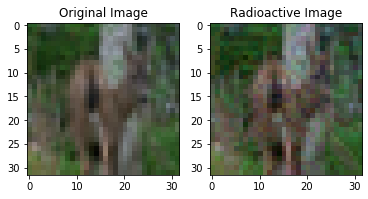

In [14]:
import numpy as np
import PIL
from matplotlib import pyplot as plt
import glob
import random
import os

def loadImageRGB(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGB')
    
radioactive_images = glob.glob('data/dump/*.npy')
radioactive_image_path = random.choice(radioactive_images)
original_image_path = f"data/img/{os.path.basename(radioactive_image_path)}".replace("npy", "png")

original_img = loadImageRGB(original_image_path)
radioactive_img = np.load(radioactive_image_path)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(original_img)
ax1.set_title("Original Image")
ax2.imshow(radioactive_img)
ax2.set_title("Radioactive Image")
plt.show()


<h1>Training A Model</h1>
<p>In this phase we take our marked CIFAR10 images above, merge them into the CIFAR10 training set using a

<h2>Creating mapping dict for marked images</h2>
<p>The existing code had a class <em>WatermarkedSet</em> which subclasses <em>torch.utils.data.Dataset</em>. It stores
a vanilla image dataset along with a dict containing a mapping of ids to the paths of watermarked replacements. 
The __getitem__ method simply returns either the vanilla image or the marked replacement if one exists for that image id.</p>
<p>Below we create the mapping dict and save it to be loaded by <em>train-classif.py</em></p>

In [16]:
import torch
import glob
import re

# Create a dict linking the original CIFAR10 image id to the location
# of the replacement marked image. Eg:
# content = { "119" : "data/dump/train_119.npy", ...}
radioactive_image_paths = glob.glob('data/dump/*.npy')
content = {}
for path in radioactive_image_paths:
    img_id = re.search('[0-9]+', path)
    content[img_id[0]] = path 

torch.save({
  'type': 'per_sample',
  'content': content
}, "data/radioactive_data.pth")
print("Radioactive image paths saved")

Radioactive image paths saved


<h2>Train Our Target Network</h2>
<p>Training a resnet18 on CIFAR10 takes about 7 hours using a high end gaming GPU.</p>

In [18]:
%%writefile config_train_classif.toml
dump_path = "data/dump" # Location of target model checkpoint & log
exp_name = "bypass"
save_periodic = 0
exp_id = ""
nb_workers = 10
fp16 = false
dataset = "cifar10"
vanilla_dataset_root = "data/datasets" # Where to download/load base CIFAR10 from
num_classes = -1 # Program will default to num_classes in dataset if we pass -1
architecture = "resnet18"
non_linearity = "relu"
pretrained = false
from_ckpt = ""
load_linear = false
train_path = "data/radioactive_data.pth"
optimizer = "sgd,lr=0.1-0.01-0.001,momentum=0.9,weight_decay=0.0001"
batch_size = 256
epochs = 90
stopping_criterion = ""
validation_metrics = ""
train_transform = "random"
seed = 0
only_train_linear = false
reload_model = ""
eval_only = false
debug_train = false
debug_slurm = false
debug = false
local_rank = -1
master_port = -1
use_cpu = false
multi_training = false # Not implemented


Overwriting config_train_classif.toml


In [1]:
%run train-classif.py

INFO - 08/29/20 16:23:47 - 0:00:00 - ============ Initialized logger ============
INFO - 08/29/20 16:23:47 - 0:00:00 - architecture: resnet18
                                     batch_size: 256
                                     command: python train-classif.py --exp_id "dump"
                                     dataset: cifar10
                                     debug: False
                                     debug_slurm: False
                                     debug_train: False
                                     dump_path: data\dump
                                     epochs: 90
                                     eval_only: False
                                     exp_id: dump
                                     exp_name: bypass
                                     fp16: False
                                     from_ckpt: 
                                     global_rank: 0
                                     is_master: True
                                    

Files already downloaded and verified


INFO - 08/29/20 16:23:47 - 0:00:01 - There are 50 watermarked examples in this dataset (0.10%)


Files already downloaded and verified


INFO - 08/29/20 16:23:48 - 0:00:02 - Building resnet18 model ...
INFO - 08/29/20 16:23:48 - 0:00:02 - Found 62 parameters in model.
INFO - 08/29/20 16:23:48 - 0:00:02 - Number of model parameters: 11.18M
INFO - 08/29/20 16:23:48 - 0:00:02 - Schedule of sgd,lr=0.1-0.01-0.001,momentum=0.9,weight_decay=0.0001: [0.1, 0.01, 0.001]
INFO - 08/29/20 16:23:48 - 0:00:02 - Optimizers: model
INFO - 08/29/20 16:23:48 - 0:00:02 - ============ Starting epoch 0 ... ============
INFO - 08/29/20 16:23:48 - 0:00:02 - New learning rate for model: 0.100000
INFO - 08/29/20 16:24:08 - 0:00:22 -       5 -   63.53 images/s - XE:  2.8852 || time:  1.2763 - model LR: 1.0000e-01
INFO - 08/29/20 16:24:16 - 0:00:29 -      10 -  180.19 images/s - XE:  4.3961 || time:  1.4197 - model LR: 1.0000e-01
INFO - 08/29/20 16:24:23 - 0:00:36 -      15 -  174.36 images/s - XE:  3.8031 || time:  1.4676 - model LR: 1.0000e-01
INFO - 08/29/20 16:24:30 - 0:00:43 -      20 -  187.38 images/s - XE:  3.0798 || time:  1.3654 - model L

INFO - 08/29/20 16:30:55 - 0:07:08 -     290 -  215.56 images/s - XE:  1.8070 || time:  1.1865 - model LR: 1.0000e-01
INFO - 08/29/20 16:31:01 - 0:07:14 -     295 -  218.83 images/s - XE:  1.8509 || time:  1.1685 - model LR: 1.0000e-01
INFO - 08/29/20 16:31:06 - 0:07:20 -     300 -  214.23 images/s - XE:  1.7848 || time:  1.1940 - model LR: 1.0000e-01
INFO - 08/29/20 16:31:12 - 0:07:26 -     305 -  218.75 images/s - XE:  1.7309 || time:  1.1693 - model LR: 1.0000e-01
INFO - 08/29/20 16:31:18 - 0:07:32 -     310 -  219.36 images/s - XE:  1.7815 || time:  1.1661 - model LR: 1.0000e-01
INFO - 08/29/20 16:31:24 - 0:07:37 -     315 -  218.29 images/s - XE:  1.8151 || time:  1.1714 - model LR: 1.0000e-01
INFO - 08/29/20 16:31:30 - 0:07:43 -     320 -  219.17 images/s - XE:  1.8001 || time:  1.1670 - model LR: 1.0000e-01
INFO - 08/29/20 16:31:36 - 0:07:50 -     325 -  201.77 images/s - XE:  1.7583 || time:  1.2677 - model LR: 1.0000e-01
INFO - 08/29/20 16:31:43 - 0:07:56 -     330 -  196.03 i

INFO - 08/29/20 16:37:58 - 0:14:11 - top5_acc -> 92.919922
INFO - 08/29/20 16:37:58 - 0:14:11 - top10_acc -> 100.000000
INFO - 08/29/20 16:37:58 - 0:14:11 - speed -> 206.823737
INFO - 08/29/20 16:37:58 - 0:14:11 - XE -> 1.646696
INFO - 08/29/20 16:37:58 - 0:14:11 - time -> 1.237769
INFO - 08/29/20 16:37:58 - 0:14:11 - __log__:{"epoch": 2, "top1_acc": 47.548828125, "top5_acc": 92.919921875, "top10_acc": 100.0, "speed": 206.8237366845758, "XE": 1.646695936820945, "time": 1.2377689529438407}
INFO - 08/29/20 16:37:58 - 0:14:11 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 16:37:58 - 0:14:11 - ============ Starting epoch 3 ... ============
INFO - 08/29/20 16:37:58 - 0:14:11 - New learning rate for model: 0.100000
INFO - 08/29/20 16:38:14 - 0:14:28 -     590 -   30.81 images/s - XE:  1.6291 || time:  1.3937 - model LR: 1.0000e-01
INFO - 08/29/20 16:38:21 - 0:14:34 -     595 -  193.59 images/s - XE:  1.6266 || time:  1.3217 - model LR: 1.0000e-01
INFO - 08/29/20 16:38:

INFO - 08/29/20 16:44:34 - 0:20:47 -     870 -  221.73 images/s - XE:  1.4574 || time:  1.1538 - model LR: 1.0000e-01
INFO - 08/29/20 16:44:40 - 0:20:53 -     875 -  219.52 images/s - XE:  1.4933 || time:  1.1653 - model LR: 1.0000e-01
INFO - 08/29/20 16:44:46 - 0:20:59 -     880 -  214.12 images/s - XE:  1.4895 || time:  1.1942 - model LR: 1.0000e-01
INFO - 08/29/20 16:44:51 - 0:21:05 -     885 -  220.27 images/s - XE:  1.5157 || time:  1.1612 - model LR: 1.0000e-01
INFO - 08/29/20 16:44:57 - 0:21:11 -     890 -  213.39 images/s - XE:  1.4976 || time:  1.1986 - model LR: 1.0000e-01
INFO - 08/29/20 16:45:04 - 0:21:17 -     895 -  209.08 images/s - XE:  1.4863 || time:  1.2231 - model LR: 1.0000e-01
INFO - 08/29/20 16:45:10 - 0:21:23 -     900 -  201.77 images/s - XE:  1.4622 || time:  1.2676 - model LR: 1.0000e-01
INFO - 08/29/20 16:45:16 - 0:21:30 -     905 -  198.94 images/s - XE:  1.5199 || time:  1.2857 - model LR: 1.0000e-01
INFO - 08/29/20 16:45:23 - 0:21:37 -     910 -  186.91 i

INFO - 08/29/20 16:51:28 - 0:27:41 - ============ End of epoch 5 ============
INFO - 08/29/20 16:51:49 - 0:28:03 - epoch -> 5.000000
INFO - 08/29/20 16:51:49 - 0:28:03 - top1_acc -> 58.437500
INFO - 08/29/20 16:51:49 - 0:28:03 - top5_acc -> 95.292969
INFO - 08/29/20 16:51:49 - 0:28:03 - top10_acc -> 100.000000
INFO - 08/29/20 16:51:49 - 0:28:03 - speed -> 206.289507
INFO - 08/29/20 16:51:49 - 0:28:03 - XE -> 1.430383
INFO - 08/29/20 16:51:49 - 0:28:03 - time -> 1.240974
INFO - 08/29/20 16:51:49 - 0:28:03 - __log__:{"epoch": 5, "top1_acc": 58.4375, "top5_acc": 95.29296875, "top10_acc": 100.0, "speed": 206.28950733559918, "XE": 1.430382835013526, "time": 1.2409744116724755}
INFO - 08/29/20 16:51:49 - 0:28:03 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 16:51:49 - 0:28:03 - ============ Starting epoch 6 ... ============
INFO - 08/29/20 16:51:49 - 0:28:03 - New learning rate for model: 0.100000
INFO - 08/29/20 16:52:08 - 0:28:22 -    1180 -   31.11 images/s - XE:  

INFO - 08/29/20 16:58:41 - 0:34:54 -    1450 -  187.39 images/s - XE:  1.2908 || time:  1.3649 - model LR: 1.0000e-01
INFO - 08/29/20 16:58:47 - 0:35:00 -    1455 -  217.19 images/s - XE:  1.3600 || time:  1.1776 - model LR: 1.0000e-01
INFO - 08/29/20 16:58:53 - 0:35:07 -    1460 -  196.53 images/s - XE:  1.3214 || time:  1.3016 - model LR: 1.0000e-01
INFO - 08/29/20 16:59:00 - 0:35:13 -    1465 -  196.06 images/s - XE:  1.2932 || time:  1.3047 - model LR: 1.0000e-01
INFO - 08/29/20 16:59:07 - 0:35:20 -    1470 -  183.88 images/s - XE:  1.3326 || time:  1.3909 - model LR: 1.0000e-01
INFO - 08/29/20 16:59:14 - 0:35:27 -    1475 -  185.45 images/s - XE:  1.2775 || time:  1.3791 - model LR: 1.0000e-01
INFO - 08/29/20 16:59:21 - 0:35:35 -    1480 -  166.22 images/s - XE:  1.3083 || time:  1.5390 - model LR: 1.0000e-01
INFO - 08/29/20 16:59:28 - 0:35:41 -    1485 -  200.36 images/s - XE:  1.3087 || time:  1.2763 - model LR: 1.0000e-01
INFO - 08/29/20 16:59:35 - 0:35:48 -    1490 -  187.27 i

INFO - 08/29/20 17:06:20 - 0:42:34 -    1760 -  194.80 images/s - XE:  1.2430 || time:  1.3131 - model LR: 1.0000e-01
INFO - 08/29/20 17:06:25 - 0:42:38 - ============ End of epoch 8 ============
INFO - 08/29/20 17:06:46 - 0:43:00 - epoch -> 8.000000
INFO - 08/29/20 17:06:46 - 0:43:00 - top1_acc -> 63.398438
INFO - 08/29/20 17:06:46 - 0:43:00 - top5_acc -> 96.328125
INFO - 08/29/20 17:06:46 - 0:43:00 - top10_acc -> 100.000000
INFO - 08/29/20 17:06:46 - 0:43:00 - speed -> 187.699469
INFO - 08/29/20 17:06:46 - 0:43:00 - XE -> 1.269694
INFO - 08/29/20 17:06:46 - 0:43:00 - time -> 1.363882
INFO - 08/29/20 17:06:46 - 0:43:00 - __log__:{"epoch": 8, "top1_acc": 63.3984375, "top5_acc": 96.328125, "top10_acc": 100.0, "speed": 187.69946910965277, "XE": 1.2696939706802368, "time": 1.3638823871709862}
INFO - 08/29/20 17:06:46 - 0:43:00 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 17:06:46 - 0:43:00 - ============ Starting epoch 9 ... ============
INFO - 08/29/20 17:06:46 -

INFO - 08/29/20 17:13:43 - 0:49:57 -    2030 -  190.49 images/s - XE:  1.1999 || time:  1.3431 - model LR: 1.0000e-01
INFO - 08/29/20 17:13:50 - 0:50:03 -    2035 -  198.94 images/s - XE:  1.1806 || time:  1.2856 - model LR: 1.0000e-01
INFO - 08/29/20 17:13:56 - 0:50:09 -    2040 -  203.28 images/s - XE:  1.2132 || time:  1.2584 - model LR: 1.0000e-01
INFO - 08/29/20 17:14:02 - 0:50:16 -    2045 -  196.77 images/s - XE:  1.1327 || time:  1.2998 - model LR: 1.0000e-01
INFO - 08/29/20 17:14:09 - 0:50:23 -    2050 -  183.56 images/s - XE:  1.1699 || time:  1.3934 - model LR: 1.0000e-01
INFO - 08/29/20 17:14:16 - 0:50:30 -    2055 -  184.18 images/s - XE:  1.1677 || time:  1.3889 - model LR: 1.0000e-01
INFO - 08/29/20 17:14:23 - 0:50:37 -    2060 -  183.15 images/s - XE:  1.2177 || time:  1.3968 - model LR: 1.0000e-01
INFO - 08/29/20 17:14:29 - 0:50:43 -    2065 -  204.14 images/s - XE:  1.1725 || time:  1.2532 - model LR: 1.0000e-01
INFO - 08/29/20 17:14:36 - 0:50:50 -    2070 -  193.42 i

INFO - 08/29/20 17:21:19 - 0:57:33 -    2340 -  174.84 images/s - XE:  1.1673 || time:  1.4633 - model LR: 1.0000e-01
INFO - 08/29/20 17:21:26 - 0:57:39 -    2345 -  197.82 images/s - XE:  1.1643 || time:  1.2933 - model LR: 1.0000e-01
INFO - 08/29/20 17:21:33 - 0:57:46 -    2350 -  184.04 images/s - XE:  1.1311 || time:  1.3903 - model LR: 1.0000e-01
INFO - 08/29/20 17:21:35 - 0:57:49 - ============ End of epoch 11 ============
INFO - 08/29/20 17:21:57 - 0:58:10 - epoch -> 11.000000
INFO - 08/29/20 17:21:57 - 0:58:10 - top1_acc -> 66.230469
INFO - 08/29/20 17:21:57 - 0:58:10 - top5_acc -> 96.894531
INFO - 08/29/20 17:21:57 - 0:58:10 - top10_acc -> 100.000000
INFO - 08/29/20 17:21:57 - 0:58:10 - speed -> 187.964969
INFO - 08/29/20 17:21:57 - 0:58:10 - XE -> 1.163289
INFO - 08/29/20 17:21:57 - 0:58:10 - time -> 1.361956
INFO - 08/29/20 17:21:57 - 0:58:10 - __log__:{"epoch": 11, "top1_acc": 66.23046875, "top5_acc": 96.89453125, "top10_acc": 100.0, "speed": 187.96496866127507, "XE": 1.163

INFO - 08/29/20 17:28:28 - 1:04:42 -    2610 -  192.02 images/s - XE:  1.0895 || time:  1.3323 - model LR: 1.0000e-01
INFO - 08/29/20 17:28:35 - 1:04:49 -    2615 -  191.81 images/s - XE:  1.0908 || time:  1.3338 - model LR: 1.0000e-01
INFO - 08/29/20 17:28:42 - 1:04:55 -    2620 -  190.10 images/s - XE:  1.0671 || time:  1.3456 - model LR: 1.0000e-01
INFO - 08/29/20 17:28:48 - 1:05:02 -    2625 -  193.76 images/s - XE:  1.0768 || time:  1.3201 - model LR: 1.0000e-01
INFO - 08/29/20 17:28:55 - 1:05:09 -    2630 -  191.45 images/s - XE:  1.1088 || time:  1.3360 - model LR: 1.0000e-01
INFO - 08/29/20 17:29:02 - 1:05:15 -    2635 -  186.74 images/s - XE:  1.1302 || time:  1.3701 - model LR: 1.0000e-01
INFO - 08/29/20 17:29:09 - 1:05:22 -    2640 -  187.20 images/s - XE:  1.1757 || time:  1.3664 - model LR: 1.0000e-01
INFO - 08/29/20 17:29:15 - 1:05:29 -    2645 -  192.14 images/s - XE:  1.2577 || time:  1.3317 - model LR: 1.0000e-01
INFO - 08/29/20 17:29:22 - 1:05:36 -    2650 -  187.99 i

INFO - 08/29/20 17:35:25 - 1:11:39 -    2920 -  220.53 images/s - XE:  1.1051 || time:  1.1598 - model LR: 1.0000e-01
INFO - 08/29/20 17:35:32 - 1:11:45 -    2925 -  207.90 images/s - XE:  1.1052 || time:  1.2305 - model LR: 1.0000e-01
INFO - 08/29/20 17:35:37 - 1:11:51 -    2930 -  219.52 images/s - XE:  1.0956 || time:  1.1654 - model LR: 1.0000e-01
INFO - 08/29/20 17:35:43 - 1:11:57 -    2935 -  216.44 images/s - XE:  1.0114 || time:  1.1819 - model LR: 1.0000e-01
INFO - 08/29/20 17:35:48 - 1:12:02 -    2940 -  254.41 images/s - XE:  1.0349 || time:  1.0055 - model LR: 1.0000e-01
INFO - 08/29/20 17:35:49 - 1:12:02 - ============ End of epoch 14 ============
INFO - 08/29/20 17:36:10 - 1:12:24 - epoch -> 14.000000
INFO - 08/29/20 17:36:10 - 1:12:24 - top1_acc -> 71.269531
INFO - 08/29/20 17:36:10 - 1:12:24 - top5_acc -> 97.978516
INFO - 08/29/20 17:36:10 - 1:12:24 - top10_acc -> 100.000000
INFO - 08/29/20 17:36:10 - 1:12:24 - speed -> 216.307668
INFO - 08/29/20 17:36:10 - 1:12:24 - XE

INFO - 08/29/20 17:41:57 - 1:18:11 -    3190 -  217.73 images/s - XE:  1.0753 || time:  1.1746 - model LR: 1.0000e-01
INFO - 08/29/20 17:42:03 - 1:18:17 -    3195 -  215.49 images/s - XE:  1.0646 || time:  1.1868 - model LR: 1.0000e-01
INFO - 08/29/20 17:42:09 - 1:18:22 -    3200 -  219.26 images/s - XE:  0.9956 || time:  1.1667 - model LR: 1.0000e-01
INFO - 08/29/20 17:42:15 - 1:18:29 -    3205 -  201.90 images/s - XE:  1.0664 || time:  1.2670 - model LR: 1.0000e-01
INFO - 08/29/20 17:42:21 - 1:18:35 -    3210 -  220.87 images/s - XE:  1.0303 || time:  1.1580 - model LR: 1.0000e-01
INFO - 08/29/20 17:42:27 - 1:18:40 -    3215 -  220.43 images/s - XE:  1.0477 || time:  1.1601 - model LR: 1.0000e-01
INFO - 08/29/20 17:42:33 - 1:18:46 -    3220 -  220.72 images/s - XE:  0.9893 || time:  1.1592 - model LR: 1.0000e-01
INFO - 08/29/20 17:42:39 - 1:18:52 -    3225 -  217.47 images/s - XE:  1.0532 || time:  1.1762 - model LR: 1.0000e-01
INFO - 08/29/20 17:42:45 - 1:18:58 -    3230 -  214.10 i

INFO - 08/29/20 17:48:51 - 1:25:05 -    3500 -  198.65 images/s - XE:  0.9854 || time:  1.2879 - model LR: 1.0000e-01
INFO - 08/29/20 17:48:57 - 1:25:11 -    3505 -  217.75 images/s - XE:  1.0665 || time:  1.1743 - model LR: 1.0000e-01
INFO - 08/29/20 17:49:04 - 1:25:17 -    3510 -  184.73 images/s - XE:  0.9974 || time:  1.3849 - model LR: 1.0000e-01
INFO - 08/29/20 17:49:10 - 1:25:23 -    3515 -  216.42 images/s - XE:  1.0585 || time:  1.1820 - model LR: 1.0000e-01
INFO - 08/29/20 17:49:16 - 1:25:29 -    3520 -  223.54 images/s - XE:  0.9780 || time:  1.1442 - model LR: 1.0000e-01
INFO - 08/29/20 17:49:22 - 1:25:35 -    3525 -  208.92 images/s - XE:  0.9908 || time:  1.2244 - model LR: 1.0000e-01
INFO - 08/29/20 17:49:25 - 1:25:38 - ============ End of epoch 17 ============
INFO - 08/29/20 17:49:46 - 1:26:00 - epoch -> 17.000000
INFO - 08/29/20 17:49:46 - 1:26:00 - top1_acc -> 72.705078
INFO - 08/29/20 17:49:46 - 1:26:00 - top5_acc -> 97.724609
INFO - 08/29/20 17:49:46 - 1:26:00 - to

INFO - 08/29/20 17:55:37 - 1:31:51 -    3770 -  199.30 images/s - XE:  1.0292 || time:  1.2834 - model LR: 1.0000e-01
INFO - 08/29/20 17:55:44 - 1:31:57 -    3775 -  194.15 images/s - XE:  0.9892 || time:  1.3175 - model LR: 1.0000e-01
INFO - 08/29/20 17:55:50 - 1:32:03 -    3780 -  217.29 images/s - XE:  1.0254 || time:  1.1771 - model LR: 1.0000e-01
INFO - 08/29/20 17:55:56 - 1:32:09 -    3785 -  211.10 images/s - XE:  0.9556 || time:  1.2117 - model LR: 1.0000e-01
INFO - 08/29/20 17:56:03 - 1:32:16 -    3790 -  181.14 images/s - XE:  1.0299 || time:  1.4122 - model LR: 1.0000e-01
INFO - 08/29/20 17:56:09 - 1:32:23 -    3795 -  199.61 images/s - XE:  1.0269 || time:  1.2815 - model LR: 1.0000e-01
INFO - 08/29/20 17:56:16 - 1:32:29 -    3800 -  187.68 images/s - XE:  0.9120 || time:  1.3628 - model LR: 1.0000e-01
INFO - 08/29/20 17:56:22 - 1:32:36 -    3805 -  207.10 images/s - XE:  0.9750 || time:  1.2352 - model LR: 1.0000e-01
INFO - 08/29/20 17:56:28 - 1:32:42 -    3810 -  216.37 i

INFO - 08/29/20 18:02:50 - 1:39:03 -    4080 -  206.38 images/s - XE:  0.9442 || time:  1.2392 - model LR: 1.0000e-01
INFO - 08/29/20 18:02:57 - 1:39:10 -    4085 -  183.75 images/s - XE:  0.9736 || time:  1.3921 - model LR: 1.0000e-01
INFO - 08/29/20 18:03:04 - 1:39:17 -    4090 -  176.60 images/s - XE:  0.9588 || time:  1.4485 - model LR: 1.0000e-01
INFO - 08/29/20 18:03:11 - 1:39:24 -    4095 -  181.77 images/s - XE:  0.9933 || time:  1.4073 - model LR: 1.0000e-01
INFO - 08/29/20 18:03:18 - 1:39:31 -    4100 -  184.02 images/s - XE:  0.9571 || time:  1.3901 - model LR: 1.0000e-01
INFO - 08/29/20 18:03:25 - 1:39:38 -    4105 -  183.70 images/s - XE:  0.9900 || time:  1.3926 - model LR: 1.0000e-01
INFO - 08/29/20 18:03:32 - 1:39:46 -    4110 -  175.04 images/s - XE:  0.9827 || time:  1.4613 - model LR: 1.0000e-01
INFO - 08/29/20 18:03:39 - 1:39:52 -    4115 -  184.65 images/s - XE:  0.8948 || time:  1.3855 - model LR: 1.0000e-01
INFO - 08/29/20 18:03:40 - 1:39:53 - ============ End of

INFO - 08/29/20 18:10:05 - 1:46:18 -    4350 -  188.51 images/s - XE:  0.9970 || time:  1.3570 - model LR: 1.0000e-01
INFO - 08/29/20 18:10:12 - 1:46:25 -    4355 -  193.99 images/s - XE:  0.9558 || time:  1.3188 - model LR: 1.0000e-01
INFO - 08/29/20 18:10:18 - 1:46:32 -    4360 -  193.04 images/s - XE:  0.9491 || time:  1.3253 - model LR: 1.0000e-01
INFO - 08/29/20 18:10:25 - 1:46:38 -    4365 -  192.31 images/s - XE:  0.9129 || time:  1.3301 - model LR: 1.0000e-01
INFO - 08/29/20 18:10:32 - 1:46:46 -    4370 -  170.41 images/s - XE:  0.9117 || time:  1.5012 - model LR: 1.0000e-01
INFO - 08/29/20 18:10:39 - 1:46:52 -    4375 -  200.25 images/s - XE:  0.8948 || time:  1.2773 - model LR: 1.0000e-01
INFO - 08/29/20 18:10:45 - 1:46:58 -    4380 -  209.47 images/s - XE:  0.9762 || time:  1.2209 - model LR: 1.0000e-01
INFO - 08/29/20 18:10:51 - 1:47:04 -    4385 -  215.91 images/s - XE:  0.9251 || time:  1.1849 - model LR: 1.0000e-01
INFO - 08/29/20 18:10:57 - 1:47:10 -    4390 -  211.15 i

INFO - 08/29/20 18:17:25 - 1:53:39 -    4660 -  191.19 images/s - XE:  0.9356 || time:  1.3378 - model LR: 1.0000e-01
INFO - 08/29/20 18:17:32 - 1:53:46 -    4665 -  184.69 images/s - XE:  0.9737 || time:  1.3851 - model LR: 1.0000e-01
INFO - 08/29/20 18:17:40 - 1:53:53 -    4670 -  170.76 images/s - XE:  0.9048 || time:  1.4982 - model LR: 1.0000e-01
INFO - 08/29/20 18:17:47 - 1:54:00 -    4675 -  184.09 images/s - XE:  0.9312 || time:  1.3897 - model LR: 1.0000e-01
INFO - 08/29/20 18:17:53 - 1:54:07 -    4680 -  192.52 images/s - XE:  0.8760 || time:  1.3288 - model LR: 1.0000e-01
INFO - 08/29/20 18:18:00 - 1:54:13 -    4685 -  192.04 images/s - XE:  0.9761 || time:  1.3321 - model LR: 1.0000e-01
INFO - 08/29/20 18:18:07 - 1:54:20 -    4690 -  183.85 images/s - XE:  0.9678 || time:  1.3915 - model LR: 1.0000e-01
INFO - 08/29/20 18:18:14 - 1:54:27 -    4695 -  189.17 images/s - XE:  0.9728 || time:  1.3522 - model LR: 1.0000e-01
INFO - 08/29/20 18:18:21 - 1:54:34 -    4700 -  173.67 i

INFO - 08/29/20 18:24:45 - 2:00:59 -    4930 -  172.33 images/s - XE:  0.8898 || time:  1.4844 - model LR: 1.0000e-01
INFO - 08/29/20 18:24:53 - 2:01:06 -    4935 -  174.23 images/s - XE:  0.9246 || time:  1.4685 - model LR: 1.0000e-01
INFO - 08/29/20 18:25:00 - 2:01:13 -    4940 -  181.53 images/s - XE:  0.8547 || time:  1.4095 - model LR: 1.0000e-01
INFO - 08/29/20 18:25:06 - 2:01:20 -    4945 -  193.32 images/s - XE:  0.9578 || time:  1.3236 - model LR: 1.0000e-01
INFO - 08/29/20 18:25:13 - 2:01:26 -    4950 -  196.25 images/s - XE:  0.9270 || time:  1.3034 - model LR: 1.0000e-01
INFO - 08/29/20 18:25:19 - 2:01:33 -    4955 -  191.23 images/s - XE:  0.9386 || time:  1.3378 - model LR: 1.0000e-01
INFO - 08/29/20 18:25:27 - 2:01:40 -    4960 -  179.63 images/s - XE:  0.9022 || time:  1.4240 - model LR: 1.0000e-01
INFO - 08/29/20 18:25:34 - 2:01:47 -    4965 -  184.66 images/s - XE:  0.8980 || time:  1.3853 - model LR: 1.0000e-01
INFO - 08/29/20 18:25:40 - 2:01:54 -    4970 -  192.01 i

INFO - 08/29/20 18:32:20 - 2:08:33 -    5240 -  170.17 images/s - XE:  0.9390 || time:  1.5033 - model LR: 1.0000e-01
INFO - 08/29/20 18:32:27 - 2:08:40 -    5245 -  174.00 images/s - XE:  0.8823 || time:  1.4700 - model LR: 1.0000e-01
INFO - 08/29/20 18:32:35 - 2:08:48 -    5250 -  163.00 images/s - XE:  0.9266 || time:  1.5697 - model LR: 1.0000e-01
INFO - 08/29/20 18:32:42 - 2:08:56 -    5255 -  174.32 images/s - XE:  0.9703 || time:  1.4673 - model LR: 1.0000e-01
INFO - 08/29/20 18:32:49 - 2:09:03 -    5260 -  176.95 images/s - XE:  0.9193 || time:  1.4456 - model LR: 1.0000e-01
INFO - 08/29/20 18:32:56 - 2:09:10 -    5265 -  182.68 images/s - XE:  0.9112 || time:  1.4004 - model LR: 1.0000e-01
INFO - 08/29/20 18:33:04 - 2:09:17 -    5270 -  180.77 images/s - XE:  0.9071 || time:  1.4151 - model LR: 1.0000e-01
INFO - 08/29/20 18:33:11 - 2:09:24 -    5275 -  176.43 images/s - XE:  0.8542 || time:  1.4499 - model LR: 1.0000e-01
INFO - 08/29/20 18:33:19 - 2:09:32 -    5280 -  166.46 i

INFO - 08/29/20 18:39:29 - 2:15:43 -    5510 -  195.94 images/s - XE:  0.8386 || time:  1.3057 - model LR: 1.0000e-01
INFO - 08/29/20 18:39:36 - 2:15:49 -    5515 -  189.00 images/s - XE:  0.8637 || time:  1.3534 - model LR: 1.0000e-01
INFO - 08/29/20 18:39:43 - 2:15:57 -    5520 -  178.05 images/s - XE:  0.9235 || time:  1.4371 - model LR: 1.0000e-01
INFO - 08/29/20 18:39:50 - 2:16:03 -    5525 -  192.18 images/s - XE:  0.8714 || time:  1.3311 - model LR: 1.0000e-01
INFO - 08/29/20 18:39:57 - 2:16:10 -    5530 -  177.38 images/s - XE:  0.8433 || time:  1.4424 - model LR: 1.0000e-01
INFO - 08/29/20 18:40:04 - 2:16:17 -    5535 -  193.27 images/s - XE:  0.9143 || time:  1.3236 - model LR: 1.0000e-01
INFO - 08/29/20 18:40:10 - 2:16:24 -    5540 -  194.21 images/s - XE:  0.9003 || time:  1.3173 - model LR: 1.0000e-01
INFO - 08/29/20 18:40:17 - 2:16:31 -    5545 -  184.17 images/s - XE:  0.8639 || time:  1.3890 - model LR: 1.0000e-01
INFO - 08/29/20 18:40:24 - 2:16:37 -    5550 -  191.09 i

INFO - 08/29/20 18:47:03 - 2:23:16 -    5820 -  193.67 images/s - XE:  0.8763 || time:  1.3207 - model LR: 1.0000e-01
INFO - 08/29/20 18:47:10 - 2:23:23 -    5825 -  191.64 images/s - XE:  0.9129 || time:  1.3350 - model LR: 1.0000e-01
INFO - 08/29/20 18:47:16 - 2:23:30 -    5830 -  193.52 images/s - XE:  0.8571 || time:  1.3219 - model LR: 1.0000e-01
INFO - 08/29/20 18:47:23 - 2:23:36 -    5835 -  186.63 images/s - XE:  0.8954 || time:  1.3708 - model LR: 1.0000e-01
INFO - 08/29/20 18:47:30 - 2:23:43 -    5840 -  189.91 images/s - XE:  0.8942 || time:  1.3471 - model LR: 1.0000e-01
INFO - 08/29/20 18:47:36 - 2:23:50 -    5845 -  191.78 images/s - XE:  0.8441 || time:  1.3336 - model LR: 1.0000e-01
INFO - 08/29/20 18:47:43 - 2:23:57 -    5850 -  184.82 images/s - XE:  0.9063 || time:  1.3843 - model LR: 1.0000e-01
INFO - 08/29/20 18:47:50 - 2:24:03 -    5855 -  193.87 images/s - XE:  0.8689 || time:  1.3193 - model LR: 1.0000e-01
INFO - 08/29/20 18:47:56 - 2:24:10 -    5860 -  200.55 i

INFO - 08/29/20 18:54:17 - 2:30:30 -    6090 -  211.46 images/s - XE:  0.7829 || time:  1.2099 - model LR: 1.0000e-02
INFO - 08/29/20 18:54:22 - 2:30:36 -    6095 -  218.42 images/s - XE:  0.7580 || time:  1.1714 - model LR: 1.0000e-02
INFO - 08/29/20 18:54:28 - 2:30:42 -    6100 -  217.62 images/s - XE:  0.7607 || time:  1.1755 - model LR: 1.0000e-02
INFO - 08/29/20 18:54:34 - 2:30:48 -    6105 -  218.71 images/s - XE:  0.7971 || time:  1.1694 - model LR: 1.0000e-02
INFO - 08/29/20 18:54:40 - 2:30:54 -    6110 -  218.62 images/s - XE:  0.7798 || time:  1.1699 - model LR: 1.0000e-02
INFO - 08/29/20 18:54:46 - 2:30:59 -    6115 -  217.38 images/s - XE:  0.8136 || time:  1.1766 - model LR: 1.0000e-02
INFO - 08/29/20 18:54:52 - 2:31:05 -    6120 -  217.99 images/s - XE:  0.7821 || time:  1.1734 - model LR: 1.0000e-02
INFO - 08/29/20 18:54:58 - 2:31:11 -    6125 -  219.90 images/s - XE:  0.7467 || time:  1.1632 - model LR: 1.0000e-02
INFO - 08/29/20 18:55:04 - 2:31:17 -    6130 -  215.26 i

INFO - 08/29/20 19:01:03 - 2:37:16 -    6400 -  220.19 images/s - XE:  0.7030 || time:  1.1618 - model LR: 1.0000e-02
INFO - 08/29/20 19:01:09 - 2:37:22 -    6405 -  219.07 images/s - XE:  0.7255 || time:  1.1677 - model LR: 1.0000e-02
INFO - 08/29/20 19:01:14 - 2:37:28 -    6410 -  220.15 images/s - XE:  0.7125 || time:  1.1619 - model LR: 1.0000e-02
INFO - 08/29/20 19:01:20 - 2:37:34 -    6415 -  218.49 images/s - XE:  0.7702 || time:  1.1705 - model LR: 1.0000e-02
INFO - 08/29/20 19:01:26 - 2:37:40 -    6420 -  207.29 images/s - XE:  0.7152 || time:  1.2340 - model LR: 1.0000e-02
INFO - 08/29/20 19:01:33 - 2:37:46 -    6425 -  208.60 images/s - XE:  0.7450 || time:  1.2261 - model LR: 1.0000e-02
INFO - 08/29/20 19:01:39 - 2:37:52 -    6430 -  209.09 images/s - XE:  0.7254 || time:  1.2230 - model LR: 1.0000e-02
INFO - 08/29/20 19:01:45 - 2:37:59 -    6435 -  193.62 images/s - XE:  0.7641 || time:  1.3209 - model LR: 1.0000e-02
INFO - 08/29/20 19:01:52 - 2:38:05 -    6440 -  202.78 i

INFO - 08/29/20 19:07:40 - 2:43:53 -    6670 -  178.47 images/s - XE:  0.7115 || time:  1.4333 - model LR: 1.0000e-02
INFO - 08/29/20 19:07:45 - 2:43:59 -    6675 -  217.40 images/s - XE:  0.6797 || time:  1.1770 - model LR: 1.0000e-02
INFO - 08/29/20 19:07:51 - 2:44:05 -    6680 -  219.57 images/s - XE:  0.7447 || time:  1.1652 - model LR: 1.0000e-02
INFO - 08/29/20 19:07:57 - 2:44:11 -    6685 -  217.38 images/s - XE:  0.6953 || time:  1.1771 - model LR: 1.0000e-02
INFO - 08/29/20 19:08:03 - 2:44:17 -    6690 -  204.59 images/s - XE:  0.7202 || time:  1.2504 - model LR: 1.0000e-02
INFO - 08/29/20 19:08:11 - 2:44:24 -    6695 -  177.56 images/s - XE:  0.7362 || time:  1.4406 - model LR: 1.0000e-02
INFO - 08/29/20 19:08:17 - 2:44:30 -    6700 -  204.89 images/s - XE:  0.7262 || time:  1.2483 - model LR: 1.0000e-02
INFO - 08/29/20 19:08:23 - 2:44:37 -    6705 -  195.19 images/s - XE:  0.6734 || time:  1.3104 - model LR: 1.0000e-02
INFO - 08/29/20 19:08:30 - 2:44:44 -    6710 -  187.46 i

INFO - 08/29/20 19:14:40 - 2:50:54 -    6980 -  219.39 images/s - XE:  0.7134 || time:  1.1659 - model LR: 1.0000e-02
INFO - 08/29/20 19:14:47 - 2:51:01 -    6985 -  184.45 images/s - XE:  0.7121 || time:  1.3868 - model LR: 1.0000e-02
INFO - 08/29/20 19:14:54 - 2:51:07 -    6990 -  194.32 images/s - XE:  0.6973 || time:  1.3162 - model LR: 1.0000e-02
INFO - 08/29/20 19:15:00 - 2:51:13 -    6995 -  214.93 images/s - XE:  0.7474 || time:  1.1901 - model LR: 1.0000e-02
INFO - 08/29/20 19:15:06 - 2:51:19 -    7000 -  218.70 images/s - XE:  0.7700 || time:  1.1698 - model LR: 1.0000e-02
INFO - 08/29/20 19:15:11 - 2:51:25 -    7005 -  218.12 images/s - XE:  0.7589 || time:  1.1724 - model LR: 1.0000e-02
INFO - 08/29/20 19:15:17 - 2:51:31 -    7010 -  219.79 images/s - XE:  0.7206 || time:  1.1639 - model LR: 1.0000e-02
INFO - 08/29/20 19:15:23 - 2:51:37 -    7015 -  208.45 images/s - XE:  0.7368 || time:  1.2268 - model LR: 1.0000e-02
INFO - 08/29/20 19:15:29 - 2:51:43 -    7020 -  219.43 i

INFO - 08/29/20 19:21:14 - 2:57:27 - ============ Starting epoch 37 ... ============
INFO - 08/29/20 19:21:14 - 2:57:27 - New learning rate for model: 0.010000
INFO - 08/29/20 19:21:31 - 2:57:45 -    7255 -   31.33 images/s - XE:  0.6825 || time:  1.3275 - model LR: 1.0000e-02
INFO - 08/29/20 19:21:37 - 2:57:51 -    7260 -  210.11 images/s - XE:  0.6881 || time:  1.2175 - model LR: 1.0000e-02
INFO - 08/29/20 19:21:43 - 2:57:57 -    7265 -  217.69 images/s - XE:  0.7165 || time:  1.1754 - model LR: 1.0000e-02
INFO - 08/29/20 19:21:49 - 2:58:03 -    7270 -  218.66 images/s - XE:  0.7076 || time:  1.1700 - model LR: 1.0000e-02
INFO - 08/29/20 19:21:55 - 2:58:09 -    7275 -  207.97 images/s - XE:  0.7269 || time:  1.2302 - model LR: 1.0000e-02
INFO - 08/29/20 19:22:02 - 2:58:15 -    7280 -  191.43 images/s - XE:  0.6872 || time:  1.3361 - model LR: 1.0000e-02
INFO - 08/29/20 19:22:08 - 2:58:22 -    7285 -  197.79 images/s - XE:  0.7477 || time:  1.2933 - model LR: 1.0000e-02
INFO - 08/29/2

INFO - 08/29/20 19:28:37 - 3:04:51 -    7560 -  219.34 images/s - XE:  0.6538 || time:  1.1663 - model LR: 1.0000e-02
INFO - 08/29/20 19:28:43 - 3:04:57 -    7565 -  218.19 images/s - XE:  0.7417 || time:  1.1722 - model LR: 1.0000e-02
INFO - 08/29/20 19:28:50 - 3:05:03 -    7570 -  193.46 images/s - XE:  0.7355 || time:  1.3220 - model LR: 1.0000e-02
INFO - 08/29/20 19:28:56 - 3:05:09 -    7575 -  216.57 images/s - XE:  0.6974 || time:  1.1813 - model LR: 1.0000e-02
INFO - 08/29/20 19:29:02 - 3:05:15 -    7580 -  213.52 images/s - XE:  0.7653 || time:  1.1979 - model LR: 1.0000e-02
INFO - 08/29/20 19:29:08 - 3:05:21 -    7585 -  219.04 images/s - XE:  0.7091 || time:  1.1677 - model LR: 1.0000e-02
INFO - 08/29/20 19:29:13 - 3:05:27 -    7590 -  220.36 images/s - XE:  0.6990 || time:  1.1607 - model LR: 1.0000e-02
INFO - 08/29/20 19:29:19 - 3:05:33 -    7595 -  211.80 images/s - XE:  0.7071 || time:  1.2075 - model LR: 1.0000e-02
INFO - 08/29/20 19:29:25 - 3:05:39 -    7600 -  212.90 i

INFO - 08/29/20 19:35:32 - 3:11:46 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 19:35:32 - 3:11:46 - ============ Starting epoch 40 ... ============
INFO - 08/29/20 19:35:32 - 3:11:46 - New learning rate for model: 0.010000
INFO - 08/29/20 19:35:52 - 3:12:06 -    7845 -   30.58 images/s - XE:  0.6776 || time:  1.2910 - model LR: 1.0000e-02
INFO - 08/29/20 19:35:58 - 3:12:12 -    7850 -  218.18 images/s - XE:  0.6865 || time:  1.1723 - model LR: 1.0000e-02
INFO - 08/29/20 19:36:04 - 3:12:17 -    7855 -  220.70 images/s - XE:  0.6872 || time:  1.1593 - model LR: 1.0000e-02
INFO - 08/29/20 19:36:10 - 3:12:24 -    7860 -  202.09 images/s - XE:  0.6997 || time:  1.2657 - model LR: 1.0000e-02
INFO - 08/29/20 19:36:17 - 3:12:31 -    7865 -  188.89 images/s - XE:  0.6724 || time:  1.3544 - model LR: 1.0000e-02
INFO - 08/29/20 19:36:25 - 3:12:38 -    7870 -  169.99 images/s - XE:  0.6923 || time:  1.5048 - model LR: 1.0000e-02
INFO - 08/29/20 19:36:32 - 3:12:45 -    787

INFO - 08/29/20 19:43:08 - 3:19:21 -    8145 -  185.56 images/s - XE:  0.6967 || time:  1.3785 - model LR: 1.0000e-02
INFO - 08/29/20 19:43:15 - 3:19:29 -    8150 -  172.65 images/s - XE:  0.6700 || time:  1.4817 - model LR: 1.0000e-02
INFO - 08/29/20 19:43:22 - 3:19:35 -    8155 -  194.83 images/s - XE:  0.6702 || time:  1.3127 - model LR: 1.0000e-02
INFO - 08/29/20 19:43:28 - 3:19:41 -    8160 -  204.01 images/s - XE:  0.6671 || time:  1.2539 - model LR: 1.0000e-02
INFO - 08/29/20 19:43:34 - 3:19:48 -    8165 -  205.73 images/s - XE:  0.6397 || time:  1.2435 - model LR: 1.0000e-02
INFO - 08/29/20 19:43:41 - 3:19:55 -    8170 -  180.73 images/s - XE:  0.6747 || time:  1.4155 - model LR: 1.0000e-02
INFO - 08/29/20 19:43:48 - 3:20:02 -    8175 -  187.30 images/s - XE:  0.6990 || time:  1.3657 - model LR: 1.0000e-02
INFO - 08/29/20 19:43:55 - 3:20:08 -    8180 -  191.51 images/s - XE:  0.6889 || time:  1.3357 - model LR: 1.0000e-02
INFO - 08/29/20 19:44:02 - 3:20:15 -    8185 -  187.63 i

INFO - 08/29/20 19:50:22 - 3:26:35 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 19:50:22 - 3:26:35 - ============ Starting epoch 43 ... ============
INFO - 08/29/20 19:50:22 - 3:26:35 - New learning rate for model: 0.010000
INFO - 08/29/20 19:50:38 - 3:26:51 -    8430 -   31.52 images/s - XE:  0.7328 || time:  1.1392 - model LR: 1.0000e-02
INFO - 08/29/20 19:50:44 - 3:26:58 -    8435 -  185.14 images/s - XE:  0.7093 || time:  1.3819 - model LR: 1.0000e-02
INFO - 08/29/20 19:50:50 - 3:27:04 -    8440 -  220.62 images/s - XE:  0.6382 || time:  1.1595 - model LR: 1.0000e-02
INFO - 08/29/20 19:50:56 - 3:27:10 -    8445 -  209.95 images/s - XE:  0.7262 || time:  1.2187 - model LR: 1.0000e-02
INFO - 08/29/20 19:51:02 - 3:27:16 -    8450 -  221.37 images/s - XE:  0.6424 || time:  1.1556 - model LR: 1.0000e-02
INFO - 08/29/20 19:51:08 - 3:27:21 -    8455 -  223.44 images/s - XE:  0.6294 || time:  1.1448 - model LR: 1.0000e-02
INFO - 08/29/20 19:51:14 - 3:27:28 -    846

INFO - 08/29/20 19:57:54 - 3:34:07 -    8730 -  193.23 images/s - XE:  0.6038 || time:  1.3238 - model LR: 1.0000e-02
INFO - 08/29/20 19:58:00 - 3:34:14 -    8735 -  192.50 images/s - XE:  0.7057 || time:  1.3289 - model LR: 1.0000e-02
INFO - 08/29/20 19:58:07 - 3:34:20 -    8740 -  191.23 images/s - XE:  0.6661 || time:  1.3377 - model LR: 1.0000e-02
INFO - 08/29/20 19:58:14 - 3:34:27 -    8745 -  193.80 images/s - XE:  0.7129 || time:  1.3200 - model LR: 1.0000e-02
INFO - 08/29/20 19:58:20 - 3:34:34 -    8750 -  192.23 images/s - XE:  0.6840 || time:  1.3307 - model LR: 1.0000e-02
INFO - 08/29/20 19:58:27 - 3:34:41 -    8755 -  185.33 images/s - XE:  0.7067 || time:  1.3803 - model LR: 1.0000e-02
INFO - 08/29/20 19:58:34 - 3:34:48 -    8760 -  177.20 images/s - XE:  0.7059 || time:  1.4438 - model LR: 1.0000e-02
INFO - 08/29/20 19:58:41 - 3:34:54 -    8765 -  201.56 images/s - XE:  0.6466 || time:  1.2691 - model LR: 1.0000e-02
INFO - 08/29/20 19:58:47 - 3:35:00 -    8770 -  209.18 i

INFO - 08/29/20 20:05:11 - 3:41:24 - time -> 1.331481
INFO - 08/29/20 20:05:11 - 3:41:24 - __log__:{"epoch": 45, "top1_acc": 82.6171875, "top5_acc": 99.052734375, "top10_acc": 100.0, "speed": 192.2671206929577, "XE": 0.6743606943257001, "time": 1.331480905717733}
INFO - 08/29/20 20:05:11 - 3:41:24 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 20:05:11 - 3:41:24 - ============ Starting epoch 46 ... ============
INFO - 08/29/20 20:05:11 - 3:41:24 - New learning rate for model: 0.010000
INFO - 08/29/20 20:05:31 - 3:41:44 -    9020 -   26.96 images/s - XE:  0.6723 || time:  1.3627 - model LR: 1.0000e-02
INFO - 08/29/20 20:05:37 - 3:41:50 -    9025 -  212.50 images/s - XE:  0.6931 || time:  1.2037 - model LR: 1.0000e-02
INFO - 08/29/20 20:05:43 - 3:41:56 -    9030 -  210.87 images/s - XE:  0.6455 || time:  1.2133 - model LR: 1.0000e-02
INFO - 08/29/20 20:05:49 - 3:42:03 -    9035 -  209.30 images/s - XE:  0.6568 || time:  1.2222 - model LR: 1.0000e-02
INFO - 08/29/20

INFO - 08/29/20 20:12:12 - 3:48:26 -    9310 -  219.66 images/s - XE:  0.6833 || time:  1.1645 - model LR: 1.0000e-02
INFO - 08/29/20 20:12:18 - 3:48:32 -    9315 -  217.18 images/s - XE:  0.6391 || time:  1.1779 - model LR: 1.0000e-02
INFO - 08/29/20 20:12:24 - 3:48:38 -    9320 -  216.92 images/s - XE:  0.6800 || time:  1.1791 - model LR: 1.0000e-02
INFO - 08/29/20 20:12:30 - 3:48:43 -    9325 -  218.56 images/s - XE:  0.6712 || time:  1.1703 - model LR: 1.0000e-02
INFO - 08/29/20 20:12:36 - 3:48:49 -    9330 -  217.97 images/s - XE:  0.6376 || time:  1.1735 - model LR: 1.0000e-02
INFO - 08/29/20 20:12:42 - 3:48:55 -    9335 -  213.19 images/s - XE:  0.6443 || time:  1.1997 - model LR: 1.0000e-02
INFO - 08/29/20 20:12:48 - 3:49:01 -    9340 -  217.03 images/s - XE:  0.6895 || time:  1.1786 - model LR: 1.0000e-02
INFO - 08/29/20 20:12:54 - 3:49:07 -    9345 -  212.46 images/s - XE:  0.7136 || time:  1.2040 - model LR: 1.0000e-02
INFO - 08/29/20 20:13:00 - 3:49:14 -    9350 -  197.38 i

INFO - 08/29/20 20:19:02 - 3:55:15 - speed -> 219.490756
INFO - 08/29/20 20:19:02 - 3:55:15 - XE -> 0.666177
INFO - 08/29/20 20:19:02 - 3:55:15 - time -> 1.166336
INFO - 08/29/20 20:19:02 - 3:55:15 - __log__:{"epoch": 48, "top1_acc": 82.48046875, "top5_acc": 99.12109375, "top10_acc": 100.0, "speed": 219.49075621285778, "XE": 0.666177439446352, "time": 1.166336133772013}
INFO - 08/29/20 20:19:02 - 3:55:15 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 20:19:02 - 3:55:15 - ============ Starting epoch 49 ... ============
INFO - 08/29/20 20:19:02 - 3:55:15 - New learning rate for model: 0.010000
INFO - 08/29/20 20:19:17 - 3:55:30 -    9605 -   31.24 images/s - XE:  0.6294 || time:  1.6190 - model LR: 1.0000e-02
INFO - 08/29/20 20:19:24 - 3:55:37 -    9610 -  180.67 images/s - XE:  0.6207 || time:  1.4163 - model LR: 1.0000e-02
INFO - 08/29/20 20:19:30 - 3:55:44 -    9615 -  207.25 images/s - XE:  0.6800 || time:  1.2341 - model LR: 1.0000e-02
INFO - 08/29/20 20:19:36

INFO - 08/29/20 20:25:29 - 4:01:43 -    9890 -  222.41 images/s - XE:  0.6487 || time:  1.1501 - model LR: 1.0000e-02
INFO - 08/29/20 20:25:35 - 4:01:48 -    9895 -  219.27 images/s - XE:  0.6743 || time:  1.1664 - model LR: 1.0000e-02
INFO - 08/29/20 20:25:41 - 4:01:54 -    9900 -  219.64 images/s - XE:  0.6771 || time:  1.1645 - model LR: 1.0000e-02
INFO - 08/29/20 20:25:47 - 4:02:00 -    9905 -  210.64 images/s - XE:  0.6144 || time:  1.2143 - model LR: 1.0000e-02
INFO - 08/29/20 20:25:53 - 4:02:06 -    9910 -  220.19 images/s - XE:  0.6547 || time:  1.1615 - model LR: 1.0000e-02
INFO - 08/29/20 20:25:59 - 4:02:12 -    9915 -  220.38 images/s - XE:  0.6644 || time:  1.1604 - model LR: 1.0000e-02
INFO - 08/29/20 20:26:04 - 4:02:18 -    9920 -  216.24 images/s - XE:  0.6607 || time:  1.1828 - model LR: 1.0000e-02
INFO - 08/29/20 20:26:10 - 4:02:24 -    9925 -  217.08 images/s - XE:  0.6748 || time:  1.1783 - model LR: 1.0000e-02
INFO - 08/29/20 20:26:16 - 4:02:30 -    9930 -  219.02 i

INFO - 08/29/20 20:32:26 - 4:08:39 - epoch -> 51.000000
INFO - 08/29/20 20:32:26 - 4:08:39 - top1_acc -> 82.841797
INFO - 08/29/20 20:32:26 - 4:08:39 - top5_acc -> 99.111328
INFO - 08/29/20 20:32:26 - 4:08:39 - top10_acc -> 100.000000
INFO - 08/29/20 20:32:26 - 4:08:39 - speed -> 213.889756
INFO - 08/29/20 20:32:26 - 4:08:39 - XE -> 0.662984
INFO - 08/29/20 20:32:26 - 4:08:39 - time -> 1.196878
INFO - 08/29/20 20:32:26 - 4:08:39 - __log__:{"epoch": 51, "top1_acc": 82.841796875, "top5_acc": 99.111328125, "top10_acc": 100.0, "speed": 213.88975566577017, "XE": 0.6629841899385258, "time": 1.196878266577818}
INFO - 08/29/20 20:32:26 - 4:08:39 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 20:32:26 - 4:08:39 - ============ Starting epoch 52 ... ============
INFO - 08/29/20 20:32:26 - 4:08:39 - New learning rate for model: 0.010000
INFO - 08/29/20 20:32:44 - 4:08:58 -   10195 -   30.67 images/s - XE:  0.7505 || time:  1.4900 - model LR: 1.0000e-02
INFO - 08/29/20 20:32:

INFO - 08/29/20 20:38:56 - 4:15:10 -   10470 -  189.43 images/s - XE:  0.6898 || time:  1.3503 - model LR: 1.0000e-02
INFO - 08/29/20 20:39:03 - 4:15:17 -   10475 -  186.22 images/s - XE:  0.6447 || time:  1.3734 - model LR: 1.0000e-02
INFO - 08/29/20 20:39:10 - 4:15:24 -   10480 -  183.69 images/s - XE:  0.6936 || time:  1.3924 - model LR: 1.0000e-02
INFO - 08/29/20 20:39:17 - 4:15:30 -   10485 -  198.73 images/s - XE:  0.6654 || time:  1.2870 - model LR: 1.0000e-02
INFO - 08/29/20 20:39:23 - 4:15:37 -   10490 -  197.65 images/s - XE:  0.5857 || time:  1.2940 - model LR: 1.0000e-02
INFO - 08/29/20 20:39:30 - 4:15:44 -   10495 -  182.07 images/s - XE:  0.6705 || time:  1.4052 - model LR: 1.0000e-02
INFO - 08/29/20 20:39:37 - 4:15:51 -   10500 -  179.04 images/s - XE:  0.6830 || time:  1.4289 - model LR: 1.0000e-02
INFO - 08/29/20 20:39:44 - 4:15:57 -   10505 -  189.25 images/s - XE:  0.6513 || time:  1.3519 - model LR: 1.0000e-02
INFO - 08/29/20 20:39:51 - 4:16:04 -   10510 -  184.25 i

INFO - 08/29/20 20:46:20 - 4:22:34 -   10780 -  245.91 images/s - XE:  0.6681 || time:  1.0401 - model LR: 1.0000e-02
INFO - 08/29/20 20:46:21 - 4:22:34 - ============ End of epoch 54 ============
INFO - 08/29/20 20:46:42 - 4:22:55 - epoch -> 54.000000
INFO - 08/29/20 20:46:42 - 4:22:55 - top1_acc -> 83.242188
INFO - 08/29/20 20:46:42 - 4:22:55 - top5_acc -> 99.062500
INFO - 08/29/20 20:46:42 - 4:22:55 - top10_acc -> 100.000000
INFO - 08/29/20 20:46:42 - 4:22:55 - speed -> 196.041663
INFO - 08/29/20 20:46:42 - 4:22:55 - XE -> 0.648745
INFO - 08/29/20 20:46:42 - 4:22:55 - time -> 1.305845
INFO - 08/29/20 20:46:42 - 4:22:55 - __log__:{"epoch": 54, "top1_acc": 83.2421875, "top5_acc": 99.0625, "top10_acc": 100.0, "speed": 196.0416628449484, "XE": 0.6487445128815514, "time": 1.3058448713652941}
INFO - 08/29/20 20:46:42 - 4:22:55 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 20:46:42 - 4:22:55 - ============ Starting epoch 55 ... ============
INFO - 08/29/20 20:46:42 

INFO - 08/29/20 20:53:34 - 4:29:47 -   11050 -  174.13 images/s - XE:  0.6337 || time:  1.4692 - model LR: 1.0000e-02
INFO - 08/29/20 20:53:41 - 4:29:55 -   11055 -  168.48 images/s - XE:  0.6421 || time:  1.5185 - model LR: 1.0000e-02
INFO - 08/29/20 20:53:48 - 4:30:01 -   11060 -  189.20 images/s - XE:  0.6423 || time:  1.3522 - model LR: 1.0000e-02
INFO - 08/29/20 20:53:55 - 4:30:09 -   11065 -  179.70 images/s - XE:  0.6552 || time:  1.4236 - model LR: 1.0000e-02
INFO - 08/29/20 20:54:02 - 4:30:15 -   11070 -  194.30 images/s - XE:  0.6523 || time:  1.3163 - model LR: 1.0000e-02
INFO - 08/29/20 20:54:08 - 4:30:21 -   11075 -  204.54 images/s - XE:  0.6429 || time:  1.2508 - model LR: 1.0000e-02
INFO - 08/29/20 20:54:15 - 4:30:28 -   11080 -  195.03 images/s - XE:  0.6306 || time:  1.3115 - model LR: 1.0000e-02
INFO - 08/29/20 20:54:21 - 4:30:35 -   11085 -  190.92 images/s - XE:  0.6711 || time:  1.3395 - model LR: 1.0000e-02
INFO - 08/29/20 20:54:28 - 4:30:42 -   11090 -  178.56 i

INFO - 08/29/20 21:01:01 - 4:37:15 -   11360 -  206.59 images/s - XE:  0.6949 || time:  1.2382 - model LR: 1.0000e-02
INFO - 08/29/20 21:01:08 - 4:37:21 -   11365 -  197.21 images/s - XE:  0.6837 || time:  1.2970 - model LR: 1.0000e-02
INFO - 08/29/20 21:01:11 - 4:37:25 - ============ End of epoch 57 ============
INFO - 08/29/20 21:01:32 - 4:37:46 - epoch -> 57.000000
INFO - 08/29/20 21:01:32 - 4:37:46 - top1_acc -> 82.792969
INFO - 08/29/20 21:01:32 - 4:37:46 - top5_acc -> 99.150391
INFO - 08/29/20 21:01:32 - 4:37:46 - top10_acc -> 100.000000
INFO - 08/29/20 21:01:32 - 4:37:46 - speed -> 196.894349
INFO - 08/29/20 21:01:32 - 4:37:46 - XE -> 0.651906
INFO - 08/29/20 21:01:32 - 4:37:46 - time -> 1.300190
INFO - 08/29/20 21:01:32 - 4:37:46 - __log__:{"epoch": 57, "top1_acc": 82.79296875, "top5_acc": 99.150390625, "top10_acc": 100.0, "speed": 196.89434944671808, "XE": 0.6519064337623363, "time": 1.3001896739006042}
INFO - 08/29/20 21:01:32 - 4:37:46 - Saving checkpoint to data\dump\checkp

INFO - 08/29/20 21:08:13 - 4:44:26 -   11630 -  188.55 images/s - XE:  0.6326 || time:  1.3566 - model LR: 1.0000e-02
INFO - 08/29/20 21:08:19 - 4:44:33 -   11635 -  196.15 images/s - XE:  0.6433 || time:  1.3041 - model LR: 1.0000e-02
INFO - 08/29/20 21:08:26 - 4:44:40 -   11640 -  182.24 images/s - XE:  0.6297 || time:  1.4038 - model LR: 1.0000e-02
INFO - 08/29/20 21:08:33 - 4:44:47 -   11645 -  187.45 images/s - XE:  0.6563 || time:  1.3649 - model LR: 1.0000e-02
INFO - 08/29/20 21:08:40 - 4:44:53 -   11650 -  195.85 images/s - XE:  0.6295 || time:  1.3060 - model LR: 1.0000e-02
INFO - 08/29/20 21:08:47 - 4:45:00 -   11655 -  179.14 images/s - XE:  0.6859 || time:  1.4278 - model LR: 1.0000e-02
INFO - 08/29/20 21:08:53 - 4:45:07 -   11660 -  204.25 images/s - XE:  0.6946 || time:  1.2528 - model LR: 1.0000e-02
INFO - 08/29/20 21:08:59 - 4:45:13 -   11665 -  200.02 images/s - XE:  0.6099 || time:  1.2791 - model LR: 1.0000e-02
INFO - 08/29/20 21:09:07 - 4:45:20 -   11670 -  181.48 i

INFO - 08/29/20 21:15:38 - 4:51:52 -   11940 -  192.54 images/s - XE:  0.6697 || time:  1.3283 - model LR: 1.0000e-03
INFO - 08/29/20 21:15:45 - 4:51:59 -   11945 -  183.11 images/s - XE:  0.6108 || time:  1.3972 - model LR: 1.0000e-03
INFO - 08/29/20 21:15:52 - 4:52:05 -   11950 -  193.68 images/s - XE:  0.6045 || time:  1.3208 - model LR: 1.0000e-03
INFO - 08/29/20 21:15:58 - 4:52:12 -   11955 -  191.87 images/s - XE:  0.6118 || time:  1.3332 - model LR: 1.0000e-03
INFO - 08/29/20 21:15:59 - 4:52:12 - ============ End of epoch 60 ============
INFO - 08/29/20 21:16:20 - 4:52:34 - epoch -> 60.000000
INFO - 08/29/20 21:16:20 - 4:52:34 - top1_acc -> 83.417969
INFO - 08/29/20 21:16:20 - 4:52:34 - top5_acc -> 99.121094
INFO - 08/29/20 21:16:20 - 4:52:34 - top10_acc -> 100.000000
INFO - 08/29/20 21:16:20 - 4:52:34 - speed -> 199.232088
INFO - 08/29/20 21:16:20 - 4:52:34 - XE -> 0.635602
INFO - 08/29/20 21:16:20 - 4:52:34 - time -> 1.284934
INFO - 08/29/20 21:16:20 - 4:52:34 - __log__:{"epoc

INFO - 08/29/20 21:22:45 - 4:58:58 -   12210 -  183.02 images/s - XE:  0.6106 || time:  1.3978 - model LR: 1.0000e-03
INFO - 08/29/20 21:22:51 - 4:59:05 -   12215 -  190.78 images/s - XE:  0.6282 || time:  1.3410 - model LR: 1.0000e-03
INFO - 08/29/20 21:22:57 - 4:59:11 -   12220 -  212.27 images/s - XE:  0.6205 || time:  1.2041 - model LR: 1.0000e-03
INFO - 08/29/20 21:23:03 - 4:59:17 -   12225 -  218.74 images/s - XE:  0.6063 || time:  1.1696 - model LR: 1.0000e-03
INFO - 08/29/20 21:23:10 - 4:59:23 -   12230 -  203.26 images/s - XE:  0.6322 || time:  1.2586 - model LR: 1.0000e-03
INFO - 08/29/20 21:23:16 - 4:59:29 -   12235 -  214.86 images/s - XE:  0.6115 || time:  1.1905 - model LR: 1.0000e-03
INFO - 08/29/20 21:23:22 - 4:59:35 -   12240 -  200.33 images/s - XE:  0.6393 || time:  1.2770 - model LR: 1.0000e-03
INFO - 08/29/20 21:23:28 - 4:59:41 -   12245 -  213.82 images/s - XE:  0.6303 || time:  1.1961 - model LR: 1.0000e-03
INFO - 08/29/20 21:23:34 - 4:59:47 -   12250 -  219.43 i

INFO - 08/29/20 21:29:47 - 5:06:01 -   12520 -  192.54 images/s - XE:  0.6503 || time:  1.3284 - model LR: 1.0000e-03
INFO - 08/29/20 21:29:55 - 5:06:08 -   12525 -  174.15 images/s - XE:  0.6188 || time:  1.4688 - model LR: 1.0000e-03
INFO - 08/29/20 21:30:01 - 5:06:15 -   12530 -  200.42 images/s - XE:  0.6230 || time:  1.2764 - model LR: 1.0000e-03
INFO - 08/29/20 21:30:07 - 5:06:21 -   12535 -  211.87 images/s - XE:  0.6299 || time:  1.2074 - model LR: 1.0000e-03
INFO - 08/29/20 21:30:13 - 5:06:27 -   12540 -  218.42 images/s - XE:  0.6085 || time:  1.1712 - model LR: 1.0000e-03
INFO - 08/29/20 21:30:17 - 5:06:31 - ============ End of epoch 63 ============
INFO - 08/29/20 21:30:39 - 5:06:52 - epoch -> 63.000000
INFO - 08/29/20 21:30:39 - 5:06:52 - top1_acc -> 83.476562
INFO - 08/29/20 21:30:39 - 5:06:52 - top5_acc -> 99.208984
INFO - 08/29/20 21:30:39 - 5:06:52 - top10_acc -> 100.000000
INFO - 08/29/20 21:30:39 - 5:06:52 - speed -> 202.200708
INFO - 08/29/20 21:30:39 - 5:06:52 - XE

INFO - 08/29/20 21:36:38 - 5:12:52 -   12790 -  189.83 images/s - XE:  0.6061 || time:  1.3475 - model LR: 1.0000e-03
INFO - 08/29/20 21:36:45 - 5:12:59 -   12795 -  177.72 images/s - XE:  0.6282 || time:  1.4394 - model LR: 1.0000e-03
INFO - 08/29/20 21:36:51 - 5:13:05 -   12800 -  205.98 images/s - XE:  0.5973 || time:  1.2418 - model LR: 1.0000e-03
INFO - 08/29/20 21:36:58 - 5:13:12 -   12805 -  188.51 images/s - XE:  0.6455 || time:  1.3567 - model LR: 1.0000e-03
INFO - 08/29/20 21:37:05 - 5:13:18 -   12810 -  192.02 images/s - XE:  0.6162 || time:  1.3321 - model LR: 1.0000e-03
INFO - 08/29/20 21:37:12 - 5:13:25 -   12815 -  189.80 images/s - XE:  0.6127 || time:  1.3480 - model LR: 1.0000e-03
INFO - 08/29/20 21:37:19 - 5:13:32 -   12820 -  187.02 images/s - XE:  0.6555 || time:  1.3676 - model LR: 1.0000e-03
INFO - 08/29/20 21:37:25 - 5:13:39 -   12825 -  185.66 images/s - XE:  0.6006 || time:  1.3776 - model LR: 1.0000e-03
INFO - 08/29/20 21:37:32 - 5:13:46 -   12830 -  183.41 i

INFO - 08/29/20 21:44:11 - 5:20:25 -   13100 -  199.28 images/s - XE:  0.5929 || time:  1.2836 - model LR: 1.0000e-03
INFO - 08/29/20 21:44:18 - 5:20:32 -   13105 -  187.19 images/s - XE:  0.6021 || time:  1.3667 - model LR: 1.0000e-03
INFO - 08/29/20 21:44:25 - 5:20:38 -   13110 -  185.92 images/s - XE:  0.6437 || time:  1.3757 - model LR: 1.0000e-03
INFO - 08/29/20 21:44:32 - 5:20:45 -   13115 -  186.64 images/s - XE:  0.6231 || time:  1.3705 - model LR: 1.0000e-03
INFO - 08/29/20 21:44:39 - 5:20:52 -   13120 -  187.31 images/s - XE:  0.5956 || time:  1.3658 - model LR: 1.0000e-03
INFO - 08/29/20 21:44:46 - 5:20:59 -   13125 -  178.82 images/s - XE:  0.6451 || time:  1.4304 - model LR: 1.0000e-03
INFO - 08/29/20 21:44:52 - 5:21:06 -   13130 -  201.21 images/s - XE:  0.5943 || time:  1.2716 - model LR: 1.0000e-03
INFO - 08/29/20 21:44:54 - 5:21:08 - ============ End of epoch 66 ============
INFO - 08/29/20 21:45:15 - 5:21:29 - epoch -> 66.000000
INFO - 08/29/20 21:45:15 - 5:21:29 - to

INFO - 08/29/20 21:51:03 - 5:27:16 -   13370 -  204.22 images/s - XE:  0.5982 || time:  1.2525 - model LR: 1.0000e-03
INFO - 08/29/20 21:51:09 - 5:27:22 -   13375 -  212.78 images/s - XE:  0.6081 || time:  1.2023 - model LR: 1.0000e-03
INFO - 08/29/20 21:51:15 - 5:27:29 -   13380 -  195.73 images/s - XE:  0.6220 || time:  1.3070 - model LR: 1.0000e-03
INFO - 08/29/20 21:51:21 - 5:27:34 -   13385 -  219.36 images/s - XE:  0.5582 || time:  1.1661 - model LR: 1.0000e-03
INFO - 08/29/20 21:51:27 - 5:27:41 -   13390 -  205.53 images/s - XE:  0.6265 || time:  1.2444 - model LR: 1.0000e-03
INFO - 08/29/20 21:51:33 - 5:27:47 -   13395 -  205.57 images/s - XE:  0.5441 || time:  1.2442 - model LR: 1.0000e-03
INFO - 08/29/20 21:51:39 - 5:27:53 -   13400 -  222.77 images/s - XE:  0.5930 || time:  1.1481 - model LR: 1.0000e-03
INFO - 08/29/20 21:51:45 - 5:27:59 -   13405 -  207.41 images/s - XE:  0.6496 || time:  1.2332 - model LR: 1.0000e-03
INFO - 08/29/20 21:51:51 - 5:28:05 -   13410 -  218.87 i

INFO - 08/29/20 21:58:19 - 5:34:33 -   13680 -  189.79 images/s - XE:  0.6173 || time:  1.3479 - model LR: 1.0000e-03
INFO - 08/29/20 21:58:27 - 5:34:40 -   13685 -  173.45 images/s - XE:  0.6315 || time:  1.4747 - model LR: 1.0000e-03
INFO - 08/29/20 21:58:34 - 5:34:47 -   13690 -  183.70 images/s - XE:  0.6735 || time:  1.3922 - model LR: 1.0000e-03
INFO - 08/29/20 21:58:41 - 5:34:54 -   13695 -  187.27 images/s - XE:  0.6373 || time:  1.3660 - model LR: 1.0000e-03
INFO - 08/29/20 21:58:48 - 5:35:01 -   13700 -  179.01 images/s - XE:  0.6116 || time:  1.4289 - model LR: 1.0000e-03
INFO - 08/29/20 21:58:54 - 5:35:08 -   13705 -  192.81 images/s - XE:  0.6280 || time:  1.3268 - model LR: 1.0000e-03
INFO - 08/29/20 21:59:01 - 5:35:15 -   13710 -  185.56 images/s - XE:  0.6684 || time:  1.3785 - model LR: 1.0000e-03
INFO - 08/29/20 21:59:08 - 5:35:21 -   13715 -  200.24 images/s - XE:  0.6151 || time:  1.2773 - model LR: 1.0000e-03
INFO - 08/29/20 21:59:14 - 5:35:27 -   13720 -  208.58 i

INFO - 08/29/20 22:05:27 - 5:41:41 -   13950 -  186.08 images/s - XE:  0.6313 || time:  1.3748 - model LR: 1.0000e-03
INFO - 08/29/20 22:05:34 - 5:41:47 -   13955 -  195.22 images/s - XE:  0.5836 || time:  1.3100 - model LR: 1.0000e-03
INFO - 08/29/20 22:05:40 - 5:41:54 -   13960 -  195.39 images/s - XE:  0.6049 || time:  1.3093 - model LR: 1.0000e-03
INFO - 08/29/20 22:05:46 - 5:42:00 -   13965 -  205.05 images/s - XE:  0.6105 || time:  1.2477 - model LR: 1.0000e-03
INFO - 08/29/20 22:05:53 - 5:42:07 -   13970 -  190.04 images/s - XE:  0.6412 || time:  1.3461 - model LR: 1.0000e-03
INFO - 08/29/20 22:06:00 - 5:42:13 -   13975 -  190.81 images/s - XE:  0.5744 || time:  1.3408 - model LR: 1.0000e-03
INFO - 08/29/20 22:06:06 - 5:42:19 -   13980 -  213.48 images/s - XE:  0.6557 || time:  1.1982 - model LR: 1.0000e-03
INFO - 08/29/20 22:06:12 - 5:42:25 -   13985 -  221.52 images/s - XE:  0.5691 || time:  1.1548 - model LR: 1.0000e-03
INFO - 08/29/20 22:06:17 - 5:42:31 -   13990 -  219.86 i

INFO - 08/29/20 22:12:47 - 5:49:01 -   14260 -  187.38 images/s - XE:  0.6226 || time:  1.3652 - model LR: 1.0000e-03
INFO - 08/29/20 22:12:54 - 5:49:08 -   14265 -  187.20 images/s - XE:  0.5977 || time:  1.3665 - model LR: 1.0000e-03
INFO - 08/29/20 22:13:01 - 5:49:14 -   14270 -  196.01 images/s - XE:  0.5837 || time:  1.3048 - model LR: 1.0000e-03
INFO - 08/29/20 22:13:07 - 5:49:21 -   14275 -  192.62 images/s - XE:  0.6252 || time:  1.3281 - model LR: 1.0000e-03
INFO - 08/29/20 22:13:14 - 5:49:28 -   14280 -  179.79 images/s - XE:  0.6170 || time:  1.4228 - model LR: 1.0000e-03
INFO - 08/29/20 22:13:22 - 5:49:35 -   14285 -  181.76 images/s - XE:  0.5972 || time:  1.4075 - model LR: 1.0000e-03
INFO - 08/29/20 22:13:29 - 5:49:42 -   14290 -  170.25 images/s - XE:  0.5957 || time:  1.5026 - model LR: 1.0000e-03
INFO - 08/29/20 22:13:36 - 5:49:50 -   14295 -  178.24 images/s - XE:  0.6550 || time:  1.4354 - model LR: 1.0000e-03
INFO - 08/29/20 22:13:43 - 5:49:57 -   14300 -  182.65 i

INFO - 08/29/20 22:20:03 - 5:56:16 -   14530 -  214.67 images/s - XE:  0.5989 || time:  1.1915 - model LR: 1.0000e-03
INFO - 08/29/20 22:20:09 - 5:56:22 -   14535 -  220.40 images/s - XE:  0.6023 || time:  1.1605 - model LR: 1.0000e-03
INFO - 08/29/20 22:20:14 - 5:56:28 -   14540 -  223.02 images/s - XE:  0.6302 || time:  1.1469 - model LR: 1.0000e-03
INFO - 08/29/20 22:20:20 - 5:56:34 -   14545 -  217.60 images/s - XE:  0.5820 || time:  1.1756 - model LR: 1.0000e-03
INFO - 08/29/20 22:20:27 - 5:56:40 -   14550 -  198.77 images/s - XE:  0.6012 || time:  1.2869 - model LR: 1.0000e-03
INFO - 08/29/20 22:20:32 - 5:56:46 -   14555 -  219.32 images/s - XE:  0.6137 || time:  1.1661 - model LR: 1.0000e-03
INFO - 08/29/20 22:20:38 - 5:56:52 -   14560 -  215.00 images/s - XE:  0.6513 || time:  1.1900 - model LR: 1.0000e-03
INFO - 08/29/20 22:20:44 - 5:56:58 -   14565 -  216.29 images/s - XE:  0.6227 || time:  1.1826 - model LR: 1.0000e-03
INFO - 08/29/20 22:20:51 - 5:57:04 -   14570 -  203.29 i

INFO - 08/29/20 22:26:57 - 6:03:10 -   14840 -  210.87 images/s - XE:  0.6436 || time:  1.2129 - model LR: 1.0000e-03
INFO - 08/29/20 22:27:03 - 6:03:16 -   14845 -  211.07 images/s - XE:  0.6450 || time:  1.2119 - model LR: 1.0000e-03
INFO - 08/29/20 22:27:08 - 6:03:22 -   14850 -  221.88 images/s - XE:  0.5932 || time:  1.1526 - model LR: 1.0000e-03
INFO - 08/29/20 22:27:14 - 6:03:28 -   14855 -  222.29 images/s - XE:  0.6042 || time:  1.1506 - model LR: 1.0000e-03
INFO - 08/29/20 22:27:20 - 6:03:34 -   14860 -  212.55 images/s - XE:  0.5714 || time:  1.2034 - model LR: 1.0000e-03
INFO - 08/29/20 22:27:26 - 6:03:40 -   14865 -  203.84 images/s - XE:  0.5759 || time:  1.2547 - model LR: 1.0000e-03
INFO - 08/29/20 22:27:32 - 6:03:46 -   14870 -  220.36 images/s - XE:  0.5696 || time:  1.1605 - model LR: 1.0000e-03
INFO - 08/29/20 22:27:38 - 6:03:52 -   14875 -  212.50 images/s - XE:  0.6330 || time:  1.2036 - model LR: 1.0000e-03
INFO - 08/29/20 22:27:45 - 6:03:58 -   14880 -  191.97 i

INFO - 08/29/20 22:33:29 - 6:09:42 -   15110 -  218.85 images/s - XE:  0.6587 || time:  1.1691 - model LR: 1.0000e-03
INFO - 08/29/20 22:33:34 - 6:09:48 -   15115 -  221.81 images/s - XE:  0.5629 || time:  1.1529 - model LR: 1.0000e-03
INFO - 08/29/20 22:33:40 - 6:09:54 -   15120 -  222.83 images/s - XE:  0.6216 || time:  1.1475 - model LR: 1.0000e-03
INFO - 08/29/20 22:33:46 - 6:09:59 -   15125 -  217.03 images/s - XE:  0.6478 || time:  1.1787 - model LR: 1.0000e-03
INFO - 08/29/20 22:33:52 - 6:10:05 -   15130 -  211.95 images/s - XE:  0.6048 || time:  1.2064 - model LR: 1.0000e-03
INFO - 08/29/20 22:33:58 - 6:10:11 -   15135 -  222.10 images/s - XE:  0.5944 || time:  1.1512 - model LR: 1.0000e-03
INFO - 08/29/20 22:34:04 - 6:10:17 -   15140 -  222.31 images/s - XE:  0.6336 || time:  1.1505 - model LR: 1.0000e-03
INFO - 08/29/20 22:34:10 - 6:10:23 -   15145 -  213.07 images/s - XE:  0.5826 || time:  1.2003 - model LR: 1.0000e-03
INFO - 08/29/20 22:34:15 - 6:10:29 -   15150 -  217.43 i

INFO - 08/29/20 22:40:27 - 6:16:41 -   15420 -  198.90 images/s - XE:  0.6248 || time:  1.2860 - model LR: 1.0000e-03
INFO - 08/29/20 22:40:34 - 6:16:48 -   15425 -  184.71 images/s - XE:  0.5936 || time:  1.3848 - model LR: 1.0000e-03
INFO - 08/29/20 22:40:41 - 6:16:55 -   15430 -  191.51 images/s - XE:  0.6266 || time:  1.3357 - model LR: 1.0000e-03
INFO - 08/29/20 22:40:47 - 6:17:00 -   15435 -  216.09 images/s - XE:  0.6066 || time:  1.1837 - model LR: 1.0000e-03
INFO - 08/29/20 22:40:53 - 6:17:06 -   15440 -  214.89 images/s - XE:  0.5851 || time:  1.1902 - model LR: 1.0000e-03
INFO - 08/29/20 22:41:00 - 6:17:14 -   15445 -  170.89 images/s - XE:  0.6235 || time:  1.4971 - model LR: 1.0000e-03
INFO - 08/29/20 22:41:07 - 6:17:20 -   15450 -  204.35 images/s - XE:  0.6065 || time:  1.2517 - model LR: 1.0000e-03
INFO - 08/29/20 22:41:13 - 6:17:26 -   15455 -  215.56 images/s - XE:  0.6317 || time:  1.1865 - model LR: 1.0000e-03
INFO - 08/29/20 22:41:19 - 6:17:33 -   15460 -  196.68 i

INFO - 08/29/20 22:47:39 - 6:23:52 -   15690 -  219.17 images/s - XE:  0.6203 || time:  1.1672 - model LR: 1.0000e-03
INFO - 08/29/20 22:47:45 - 6:23:58 -   15695 -  202.29 images/s - XE:  0.6010 || time:  1.2651 - model LR: 1.0000e-03
INFO - 08/29/20 22:47:52 - 6:24:05 -   15700 -  186.71 images/s - XE:  0.6281 || time:  1.3702 - model LR: 1.0000e-03
INFO - 08/29/20 22:47:59 - 6:24:12 -   15705 -  179.74 images/s - XE:  0.6516 || time:  1.4233 - model LR: 1.0000e-03
INFO - 08/29/20 22:48:06 - 6:24:19 -   15710 -  183.89 images/s - XE:  0.5998 || time:  1.3909 - model LR: 1.0000e-03
INFO - 08/29/20 22:48:13 - 6:24:26 -   15715 -  180.83 images/s - XE:  0.6281 || time:  1.4146 - model LR: 1.0000e-03
INFO - 08/29/20 22:48:20 - 6:24:33 -   15720 -  188.07 images/s - XE:  0.6106 || time:  1.3601 - model LR: 1.0000e-03
INFO - 08/29/20 22:48:26 - 6:24:40 -   15725 -  192.33 images/s - XE:  0.6040 || time:  1.3300 - model LR: 1.0000e-03
INFO - 08/29/20 22:48:33 - 6:24:47 -   15730 -  186.83 i

INFO - 08/29/20 22:55:18 - 6:31:31 -   16000 -  189.20 images/s - XE:  0.6554 || time:  1.3517 - model LR: 1.0000e-03
INFO - 08/29/20 22:55:25 - 6:31:38 -   16005 -  189.06 images/s - XE:  0.6269 || time:  1.3531 - model LR: 1.0000e-03
INFO - 08/29/20 22:55:31 - 6:31:45 -   16010 -  189.72 images/s - XE:  0.6521 || time:  1.3484 - model LR: 1.0000e-03
INFO - 08/29/20 22:55:39 - 6:31:52 -   16015 -  173.57 images/s - XE:  0.6121 || time:  1.4739 - model LR: 1.0000e-03
INFO - 08/29/20 22:55:46 - 6:31:59 -   16020 -  182.99 images/s - XE:  0.5929 || time:  1.3979 - model LR: 1.0000e-03
INFO - 08/29/20 22:55:53 - 6:32:06 -   16025 -  181.51 images/s - XE:  0.6359 || time:  1.4095 - model LR: 1.0000e-03
INFO - 08/29/20 22:56:00 - 6:32:13 -   16030 -  188.06 images/s - XE:  0.6423 || time:  1.3603 - model LR: 1.0000e-03
INFO - 08/29/20 22:56:07 - 6:32:20 -   16035 -  183.02 images/s - XE:  0.6321 || time:  1.3978 - model LR: 1.0000e-03
INFO - 08/29/20 22:56:13 - 6:32:27 -   16040 -  194.61 i

INFO - 08/29/20 23:02:44 - 6:38:58 -   16270 -   31.27 images/s - XE:  0.5977 || time:  1.3625 - model LR: 1.0000e-03
INFO - 08/29/20 23:02:52 - 6:39:05 -   16275 -  180.64 images/s - XE:  0.6070 || time:  1.4163 - model LR: 1.0000e-03
INFO - 08/29/20 23:02:59 - 6:39:12 -   16280 -  182.45 images/s - XE:  0.6118 || time:  1.4025 - model LR: 1.0000e-03
INFO - 08/29/20 23:03:06 - 6:39:19 -   16285 -  180.22 images/s - XE:  0.6333 || time:  1.4197 - model LR: 1.0000e-03
INFO - 08/29/20 23:03:13 - 6:39:26 -   16290 -  187.08 images/s - XE:  0.5747 || time:  1.3674 - model LR: 1.0000e-03
INFO - 08/29/20 23:03:19 - 6:39:33 -   16295 -  194.70 images/s - XE:  0.5719 || time:  1.3138 - model LR: 1.0000e-03
INFO - 08/29/20 23:03:27 - 6:39:40 -   16300 -  172.54 images/s - XE:  0.5909 || time:  1.4829 - model LR: 1.0000e-03
INFO - 08/29/20 23:03:33 - 6:39:47 -   16305 -  193.74 images/s - XE:  0.6016 || time:  1.3202 - model LR: 1.0000e-03
INFO - 08/29/20 23:03:40 - 6:39:53 -   16310 -  187.78 i

INFO - 08/29/20 23:10:08 - 6:46:21 -   16580 -  191.16 images/s - XE:  0.6052 || time:  1.3381 - model LR: 1.0000e-03
INFO - 08/29/20 23:10:14 - 6:46:28 -   16585 -  199.19 images/s - XE:  0.5965 || time:  1.2842 - model LR: 1.0000e-03
INFO - 08/29/20 23:10:21 - 6:46:34 -   16590 -  189.43 images/s - XE:  0.5602 || time:  1.3502 - model LR: 1.0000e-03
INFO - 08/29/20 23:10:28 - 6:46:42 -   16595 -  176.94 images/s - XE:  0.5909 || time:  1.4456 - model LR: 1.0000e-03
INFO - 08/29/20 23:10:36 - 6:46:49 -   16600 -  172.07 images/s - XE:  0.5975 || time:  1.4867 - model LR: 1.0000e-03
INFO - 08/29/20 23:10:42 - 6:46:55 -   16605 -  199.42 images/s - XE:  0.6750 || time:  1.2827 - model LR: 1.0000e-03
INFO - 08/29/20 23:10:49 - 6:47:02 -   16610 -  187.70 images/s - XE:  0.5924 || time:  1.3629 - model LR: 1.0000e-03
INFO - 08/29/20 23:10:56 - 6:47:09 -   16615 -  189.55 images/s - XE:  0.6123 || time:  1.3494 - model LR: 1.0000e-03
INFO - 08/29/20 23:11:03 - 6:47:16 -   16620 -  179.54 i

INFO - 08/29/20 23:16:52 - 6:53:06 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 23:16:53 - 6:53:06 - ============ Starting epoch 86 ... ============
INFO - 08/29/20 23:16:53 - 6:53:06 - New learning rate for model: 0.001000
INFO - 08/29/20 23:17:11 - 6:53:25 -   16860 -   31.36 images/s - XE:  0.6252 || time:  1.3063 - model LR: 1.0000e-03
INFO - 08/29/20 23:17:17 - 6:53:31 -   16865 -  220.45 images/s - XE:  0.6412 || time:  1.1605 - model LR: 1.0000e-03
INFO - 08/29/20 23:17:23 - 6:53:37 -   16870 -  207.36 images/s - XE:  0.5925 || time:  1.2338 - model LR: 1.0000e-03
INFO - 08/29/20 23:17:29 - 6:53:43 -   16875 -  210.80 images/s - XE:  0.5839 || time:  1.2136 - model LR: 1.0000e-03
INFO - 08/29/20 23:17:36 - 6:53:50 -   16880 -  188.71 images/s - XE:  0.6014 || time:  1.3556 - model LR: 1.0000e-03
INFO - 08/29/20 23:17:43 - 6:53:56 -   16885 -  194.21 images/s - XE:  0.6244 || time:  1.3169 - model LR: 1.0000e-03
INFO - 08/29/20 23:17:49 - 6:54:03 -   1689

INFO - 08/29/20 23:24:17 - 7:00:31 -   17160 -  184.84 images/s - XE:  0.6102 || time:  1.3839 - model LR: 1.0000e-03
INFO - 08/29/20 23:24:24 - 7:00:37 -   17165 -  187.12 images/s - XE:  0.5763 || time:  1.3671 - model LR: 1.0000e-03
INFO - 08/29/20 23:24:31 - 7:00:44 -   17170 -  184.14 images/s - XE:  0.6035 || time:  1.3890 - model LR: 1.0000e-03
INFO - 08/29/20 23:24:38 - 7:00:51 -   17175 -  189.42 images/s - XE:  0.6159 || time:  1.3505 - model LR: 1.0000e-03
INFO - 08/29/20 23:24:45 - 7:00:58 -   17180 -  182.73 images/s - XE:  0.6080 || time:  1.3999 - model LR: 1.0000e-03
INFO - 08/29/20 23:24:52 - 7:01:05 -   17185 -  179.75 images/s - XE:  0.6176 || time:  1.4232 - model LR: 1.0000e-03
INFO - 08/29/20 23:24:59 - 7:01:12 -   17190 -  190.68 images/s - XE:  0.6054 || time:  1.3415 - model LR: 1.0000e-03
INFO - 08/29/20 23:25:05 - 7:01:19 -   17195 -  185.84 images/s - XE:  0.5979 || time:  1.3764 - model LR: 1.0000e-03
INFO - 08/29/20 23:25:12 - 7:01:26 -   17200 -  181.76 i

INFO - 08/29/20 23:31:42 - 7:07:56 - Saving checkpoint to data\dump\checkpoint-0.pth ...
INFO - 08/29/20 23:31:42 - 7:07:56 - ============ Starting epoch 89 ... ============
INFO - 08/29/20 23:31:42 - 7:07:56 - New learning rate for model: 0.001000
INFO - 08/29/20 23:31:57 - 7:08:11 -   17445 -   30.75 images/s - XE:  0.5498 || time:  1.4398 - model LR: 1.0000e-03
INFO - 08/29/20 23:32:05 - 7:08:18 -   17450 -  177.41 images/s - XE:  0.6223 || time:  1.4424 - model LR: 1.0000e-03
INFO - 08/29/20 23:32:12 - 7:08:25 -   17455 -  177.78 images/s - XE:  0.5930 || time:  1.4391 - model LR: 1.0000e-03
INFO - 08/29/20 23:32:19 - 7:08:32 -   17460 -  188.19 images/s - XE:  0.6354 || time:  1.3595 - model LR: 1.0000e-03
INFO - 08/29/20 23:32:25 - 7:08:39 -   17465 -  190.31 images/s - XE:  0.6121 || time:  1.3444 - model LR: 1.0000e-03
INFO - 08/29/20 23:32:32 - 7:08:46 -   17470 -  183.36 images/s - XE:  0.6370 || time:  1.3952 - model LR: 1.0000e-03
INFO - 08/29/20 23:32:39 - 7:08:52 -   1747

<h1>Detecting if a model is radioactive</h1>
<p>In progress...</p>
So now we use the carriers and the trained network to detect the radioactive marks.

On the output, you should obtain a line with "log10(p)=...", which gives the (log of the) p-value of radioactivity detection.

In [1]:
%%writefile config_detect_radioactivity.toml
dataset = "cifar10"
dataset_root = "data/datasets"

# Image scaling pre feeding to networks
# Will need extra params if we have different marking and target networks??
crop_size = 224
img_size = 256

carrier_path = "data/carriers.pth"
marking_network = "data/pretrained_resnet18.pth"
target_network = "data/dump/checkpoint-0.pth"

batch_size = 64
nb_workers = 20
seed = 1

Overwriting config_detect_radioactivity.toml


In [ ]:
%run detect_radioactivity.py 